# <div align="center"><b> *Transformers* para series de tiempo </b></div>

<div align="right">

<!-- [![Binder](http://mybinder.org/badge.svg)](https://mybinder.org/) -->
[![nbviewer](https://img.shields.io/badge/render-nbviewer-orange?logo=Jupyter)](https://nbviewer.org/github/brunomaso1/uba-mia/blob/mia-ast2/mia-ast2/TPFinal.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/brunomaso1/uba-mia/blob/mia-ast2/mia-ast2/TPFinal.ipynb)

</div>

* * *

<style>
/* Limitar la altura de las celdas de salida en html */
.jp-OutputArea.jp-Cell-outputArea {
    max-height: 500px;
}
</style>

🛻 <em><font color='MediumSeaGreen'>  Instalaciones: </font></em> 🛻

Este notebook utiliza [Poetry](https://python-poetry.org/) para la gestión de dependencias.
Primero instala Poetry siguiendo las instrucciones de su [documentación oficial](https://python-poetry.org/docs/#installation).
Luego ejecuta el siguiente comando para instalar las dependencias necesarias y activar el entorno virtual:

- Bash:
```bash
poetry install
eval $(poetry env activate)
```

- PowerShell:
```powershell
poetry install
Invoke-Expression (poetry env activate)
```

✋ <em><font color='DodgerBlue'>Importaciones:</font></em> ✋

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

import keras
from keras import Input, Model
from keras.layers import (
    LayerNormalization,
    MultiHeadAttention,
    Dropout,
    LayerNormalization,
    Conv1D,
    Dense,
    GlobalAveragePooling1D,
    Layer,
    Embedding,
)
from keras.callbacks import EarlyStopping, History
from keras.losses import MeanSquaredError
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError

from sklearn import metrics

from typing import Tuple

from pprint import pprint

import torch
from transformers import TimesFmModelForPrediction

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

🔧 <em><font color='tomato'>Configuraciones:</font></em> 🔧


In [2]:
WINDOW_SIZE = 5
EMMBEDDING_DIM = 8
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

<!-- Colab -->
<!-- <div align="center"><img src="https://drive.google.com/uc?export=view&id=1QSNrTsz1hQbmZwpgwx0qpfpNtLW19Orm" width="600" alt="Figura 1: A data scientist is working on word generation using the Lord of the Rings lore. The image is dark and moody, with a focus on the scientist's computer screen. The screen displays a visualization the one ring, with a map of Middle Earth in the background. - Generada con DALL-E3"></div> -->

<div align="center"><img src="resources/portada.jpeg" width="600" alt="Figura 1: A data scientist playing with convolutional neural networks. - Generada con Microsoft Image Creator"></div>

<div align="center"><small><em>Figura 1: Un científico analizando series de tiempo de mercados financieros utilizando redes neuronales</em></small></div>

<div align="center">✨Datos del proyecto:✨</div>

<p></p>

<div align="center">

| Subtitulo       | Transformers en series de tiempo - Análisis de series temporales 2 - FIUBA                                                             |
| --------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| **Descrpción**  | <small>Estudio sobre la aplicación de *Transformers* en series de tiempo.</small>                                                                        |
| **Integrantes** | <small>- Bruno Masoller (brunomaso1@gmail.com)</br>- Fabricio Denardi (denardifabricio@gmail.com) </br>- Francisco Rassi (franciscorassi@gmail.com)</small>                                                          |

</div>

## Tabla de Contenido

* [1. Introducción a los *Transformers*](#chapter1)
* [2. Transformers para series de tiempo](#chapter2)
* [2.1. Embeddings y positional encoding](#section2_1)
* [3. Caso práctico](#chapter3)
  * [3.1. Transformer base](#section3_1)
  * [3.2. Transformer + positional encoding](#section3_2)
* [4. Estado del arte](#chapter4)
  * [4.1 Caso de uso: TimesFM](#section_4_1)
* [5. Resultados](#chapter5)
  * [5.1. Conclusiones](#section5_1)
  * [5.2. Mejoras y futuras lineas de investigación](#section5_2)
* [6. Referencias](#chapter6)

## 1. Introducción a los *Transformers* <a class="anchor" id="chapter1"></a>

Los *Transformers* son una arquitectura de red neuronal introducida en el artículo "Attention is All You Need" por Vaswani et al. en 2017. Originalmente diseñados para tareas de procesamiento de lenguaje natural (NLP), los *Transformers* han demostrado ser altamente efectivos en una variedad de tareas, incluyendo traducción automática, generación de texto y análisis de sentimientos.
Esta arquitectura se basa en el mecanismo de atención, que permite a la red enfocarse en diferentes partes de la entrada de manera dinámica, lo que mejora la capacidad de modelar relaciones a largo plazo en los datos. Una representación visual del artículo puede verse en la siguiente figura:

<div align="center">
    <img src="resources/transformer-vanilla.png" width="400" alt="Figura: Arquitectura del Transformer según Vaswani et al. (2017)">
    <br>
    <small><em>Figura: Arquitectura del Transformer, tomada de "Attention is All You Need" (Vaswani et al., 2017).</em></small>
</div>

Más allá de su éxito en NLP, los *Transformers* han sido adaptados para otras áreas, como visión por computadora, en el artículo "An Image is Worth 16x16 Words" por Dosovitskiy et al. en 2020, donde se introdujo el Vision Transformer (ViT); en el modelado espacio-temporal, introducido en el artículo "A 3d high-resolution model for fast and accurate global weather forecast" por Bi et al. en 2022; o en reconocimiento de voz, como se describe en el artículo "Speech-Transformer: a no-recurrence sequence-to-sequence model for speech recognition" por Dong et al. en 2018.
En series de tiempo, también se han explorado diversas adaptaciones de *Transformers*.

El objetivo de este trabajo es explorar el uso de *Transformers* en series de tiempo, centrándonos en su aplicación para la predicción de series temporales financieras. A través de un conjunto de datos clásico, como lo es el precio del *Bitcoin*, analizaremos el rendimiento de varios tipos de *Transformers*.

> 💫 <em><font color='MediumPurple'> Más información: </font></em> Esta es una breve introducción, si deseas más información puedes mirar este artículo donde se explica don profundidad varios conceptos: https://arxiv.org/pdf/2304.10557

## 2. Transformers para series de tiempo <a class="anchor" id="chapter2"></a>

La predicción de series de tiempo enfrenta varios desafíos debido a las características propias de los datos. Usualmente, estos desafíos se asocian con conceptos de estacionaridad, linearidad y naturaleza caótica. Enfoques tradicionales basados en aprendizaje profundo como RNN (*Recurrent Neural Networks*), LSTMs (*Long Short-Term Memory*) o GRU (*Gated Recurrent Units*) procesan los datos de forma secuencial pero son ineficientes para secuencias largas. 

Para superar estos desafíos, una linea de investigación moderna se basa en la aplicación de los *Transformers* a estas secuencias de datos, focalizándose en las ventajas que presentan estas arquitecturas en el procesamiento de datos. Entre lás principales ventajas se encuentran:
- **Paralelización**: A diferencia de las RNN, los *Transformers* permiten el procesamiento paralelo de secuencias, lo que acelera el entrenamiento y la inferencia.
- **Atención**: El mecanismo de atención permite a los *Transformers* enfocarse en diferentes partes de la secuencia de entrada, capturando relaciones a largo plazo y mejorando la capacidad de modelar dependencias complejas.
- **Escalabilidad**: Los *Transformers* son altamente escalables y pueden manejar secuencias de longitud variable, lo que los hace adecuados para una amplia gama de tareas de series de tiempo.

En base al artículo "A Survey on Transformers for Time Series Forecasting" de Wu et al. (2023), una posible taxonomía para clasificar a los *Transformers* para series de tiempo se puede dividir en dos categorías principales: según su arquitectura y según su aplicación, como puede verse en la siguiente figura:

<div align="center">
    <img src="resources/taxonomia-paper.png" width="400" alt="Figura: Taxonomía de Transformers para series de tiempo según Wu et al. (2023)">
    <br>
    <small><em>Figura: Taxonomía de Transformers para series de tiempo según Wu et al. (2023).</em></small>
</div>

Un resumen de esta clasificación es el siguiente:
- Clasificación según modificaciones en la arquitectura:
  - Modificaciones en "Positional Encoding".
    - Vanilla positional encoding.
    - Learnable positional encoding.
    - Timestamp encoding
  - Modificaciones (optimizaciones) en el módulo de atención.
    - Introducción de sesgo espacial (LogTrans y Pyraformer)
    - Exploración de las propiedades low-rank de la matriz de atención (Informer y FEDformer)
  - Inovación en la arquitectura de la atención
    - Arquitecturas jerárquicas
- Clasificación según el tipo de aplicación.
  - Predicción
    - Predicción de series temporales (Informer, etc.)
    - Predicciones temporales-espaciales
    - Predicciones de eventos.
  - Detección de anomalías
  - Clasificación

Varias variantes de *Transformers* han sido propuestas para abordar estos desafíos, cada una con sus propias innovaciones y optimizaciones. Por ejemplo, según la tarea de predicción, se puede nombrar los artículos de "Enhancing the locality and breaking the memory bottleneck of transformer on time series forecasting" por Li et al. (2019) o "Informer: Beyond efficient transformer for long sequence time-series forecasting" por Zhou et al. (2021), que introducen optimizaciones en el módulo de atención para mejorar la eficiencia y la precisión en la predicción de series temporales. Así mismo, para la detección de anomalías, se puede mencionar el artículo "TranAD: Deep transformer networks for anomaly detection in multivariate time series" por Zheng et al. (2021) o el artículo "Voice2Series: Reprograming acoustic models for time series classification" por Yang et al. (2021) para la tarea de clasificación.

Sin embargo, a pesar de los avances en el uso de *Transformers* para series de tiempo, aún existen desafíos y limitaciones, especialmente en como efectivamente modelar series temporales complejas para capturar la estacionalidad, como se nombra en el artículo "Robust time series anlaysis and applications: An industrial perspective" por Wen et al. (2022).

En base a esa curiosidad, en las siguientes secciones se explorará el uso de *Transformers* para series de tiempo, centrándose en su aplicación para la predicción de series temporales financieras. A través de un conjunto de datos clásico, como lo es el precio del *Bitcoin*, analizaremos el rendimiento de varios tipos de *Transformers*.

### 2.1. Embeddings y Positional Encoding <a class="anchor" id="section2_1"></a>

Los *Transformers* proveen una poderosa arquitectura para el procesamiento de una amplia gama de modalidades de datos, como textos e imágenes (explicados anteriormente). En todos estos casos, los datos en "crudo" (raw data) deben primeramente ser "tokenizados" para que se conviertan en una secuencia de vectores que luego pueden ser procesados por el modelo. Debido a que los *Transformers* son invariantes a las permutaciones de los datos, es necesario incorporar información de orden en la secuencia de entrada. Para esto, se utiliza el "positional encoding", que agrega información de posición a cada token en la secuencia.

Existen varias formas de "tokenizar" las series de tiempo, entre las cuales se encuentran utilizar mutli-series para representar mejor la información semántica, que al utilizar varios canales, mejora la información semántica local, como se comenta en el paper "A time series is worth 64 words: Long-term forecasting with transformers" por Nie et al. (2023). Otras formas incluyen características (handcrafted features) adicionales, como feriados o días especiales, como el modelo Informer.

En la siguiente sección se muestra un ejemplo para un caso "sin positional encoding" y otro "con positional encoding" como estudio.

## 3. Caso práctico <a class="anchor" id="chapter3"></a>

Esta sección tiene como objetivo presentar un caso práctico de aplicación de *Transformers* a series de tiempo. El enfoque principal se centra en explorar la construcción de modelos de predicción de series temporales utilizando la arquitectura *Transformer*, construídos de forma "manual" utilizando *Keras*.

Se divide en dos partes, por un lado, se realiza la implementación de un modelo *Transformer* desde cero, en donde las entradas son simplemente series de tiempo univariadas. Por otro lado, se explora y analiza una codificación posicional alternativa, que permite incorporar información adicional al modelo.

Las capas utilizadas en este caso práctico (como sus enlaces a la documentación oficial) son:
- [MultiHeadAttention](https://keras.io/api/layers/attention_layers/multi_head_attention/)
- [PositionalEncoding](https://keras.io/api/layers/positional_encoding/)
- [Conv1D](https://keras.io/api/layers/convolution_layers/convolution1d/)
- [Dropout](https://keras.io/api/layers/regularization_layers/dropout/)
- [Dense](https://keras.io/api/layers/core_layers/dense/)
- [LayerNormalization](https://keras.io/api/layers/normalization_layers/layer_normalization/)
- [Input](https://keras.io/api/layers/core_layers/input/)
- [Flatten](https://keras.io/api/layers/core_layers/flatten/)

Para este ejemplo, se utilizará el mismo conjunto de datos que se utilizó en la primera versión de la materia (precio del *Bitcon* obtenido desde Binance), el cual se encuentra disponible en: https://github.com/brunomaso1/uba-mia/tree/mia-ast1/mia-ast1/Trabajo%20final/datasets.

Las métricas obtenidas en ese trabajo fueron las siguientes:

In [3]:
df_metrics = pd.read_csv('resources/previous_metrics_comparison.csv')
df_metrics

,model,mae,mape,rmse
0,Naive,1735.726500,1.888647,2434.504211
1,"ARIMA(1,1,35)",1891.662281,2.063588,2546.257391
2,"ARIMA(0,1,0)",1735.726500,1.894494,2434.504211
3,Prophet,2582.551322,2.871448,3621.703076
4,XGBoost (ST original),4319.031819,4.609317,5555.304516
5,XGBoost (ST diferenciada),1220.061373,290.783756,1849.183184
6,LSTM,2432.965561,2.645095,3192.781096


Cargamos el conjunto de datos:

In [4]:
df = pd.read_pickle('resources/BTCUSDT_1D.pkl')
df.head()

,Open,High,Low,Close,Volume,Close Time,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume,Ignore
Open Time,,,,,,,,,,,
2024-03-01,61130.99,63114.23,60777.00,62387.90,47737.93473,2024-03-01 23:59:59.999,2.956537e+09,1947444,24195.70252,1.498771e+09,0
2024-03-02,62387.90,62433.19,61561.12,61987.28,25534.73659,2024-03-02 23:59:59.999,1.582567e+09,1641808,12691.37721,7.865831e+08,0
2024-03-03,61987.28,63231.88,61320.00,63113.97,28994.90903,2024-03-03 23:59:59.999,1.804536e+09,1992011,14905.18600,9.278690e+08,0
2024-03-04,63113.97,68499.00,62300.00,68245.71,84835.16005,2024-03-04 23:59:59.999,5.568878e+09,3887853,45319.08640,2.974396e+09,0
2024-03-05,68245.71,69000.00,59005.00,63724.01,132696.78130,2024-03-05 23:59:59.999,8.674527e+09,5310706,65991.84526,4.318206e+09,0


En este caso, nos quedamos solo con la columna de "Close" del conjunto de datos, que representa el precio de cierre de BTC:

In [5]:
df = df[['Close']]
df.head()

,Close
Open Time,
2024-03-01,62387.90
2024-03-02,61987.28
2024-03-03,63113.97
2024-03-04,68245.71
2024-03-05,63724.01


Guardamos una copia:

In [6]:
df.to_csv('resources/BTCUSDT_1D.csv', index=True)

Inicialmente, realizamos un test de estacionaridad, utilizando la prueba de Dickey-Fuller aumentada (ADF). Para ello, generamos una función auxiliar que realice el test:

In [7]:
def test_stationarity(timeseries: pd.DataFrame) -> None:
    """
    Realiza la prueba de Dickey-Fuller aumentada (ADF) para evaluar la estacionaridad de una serie temporal.

    Args:
        timeseries (pd.DataFrame): Serie temporal a evaluar, puede ser un DataFrame o una Serie de pandas.

    Prints:
        Estadístico ADF, valor p y conclusión sobre la estacionaridad de la serie.
    """
    adf_result = adfuller(timeseries)
    print("ADF Statistic:", adf_result[0])
    print("p-value:", adf_result[1])

    if adf_result[1] <= 0.05:
        print("La serie es estacionaria (rechazamos H0)")
    else:
        print("La serie no es estacionaria (no rechazamos H0)")

Realizamos el test:

In [8]:
test_stationarity(df)

ADF Statistic: -1.420856101366877
p-value: 0.5722376131152292
La serie no es estacionaria (no rechazamos H0)


> 📝 <em><font color='Gray'>Nota:</font></em> Se podría realizar otras pruebas como KPSS, no linealidad (BDS), normalidad (Shapiro-Wilks), etc. pero no es el objetivo de este trabajo. Por más información sobre el conjunto de datos, se puede acceder en el siguiente enlace: https://github.com/brunomaso1/uba-mia/blob/mia-ast1/mia-ast1/Trabajo%20final/tp-final.ipynb 

Dividimos el conjunto de datos en entrenamiento y test (también convertimos los datos en listas):

In [9]:
train_size = int(len(df) * 0.9)
df_train, df_test = df[:train_size].values, df[train_size:].values

spots_train, spots_test = df_train.tolist(), df_test.tolist()

print(f"Train size: {len(spots_train)}")
print(f"Test size: {len(spots_test)}")

Train size: 356
Test size: 40


Definimos una función auxiliar para crear las secuencias de datos:

In [10]:
def to_sequences(seq_size: int, obs: list) -> Tuple[np.ndarray, np.ndarray]:
    """
    Genera secuencias de longitud fija y sus correspondientes etiquetas para problemas de series temporales.

    Args:
        seq_size (int): Tamaño de la ventana o longitud de cada secuencia.
        obs (list): Lista de observaciones (puede ser una lista de listas o valores).

    Returns:
        tuple[np.ndarray, np.ndarray]: 
            - x: Array de secuencias de entrada de tamaño (n_samples, seq_size, ...).
            - y: Array de valores objetivo correspondientes a cada secuencia.
    """
    x = [np.array(obs[i : i + seq_size]) for i in range(len(obs) - seq_size)]
    y = [obs[i + seq_size] for i in range(len(obs) - seq_size)]
    return np.array(x), np.array(y)

Creamos las secuencias de datos:

In [11]:
X_train, y_train = to_sequences(WINDOW_SIZE, spots_train)
X_test, y_test = to_sequences(WINDOW_SIZE, spots_test)
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (351, 5, 1)
y_train shape: (351, 1)
X_test shape: (35, 5, 1)
y_test shape: (35, 1)


### 3.1. Transformer base <a class="anchor" id="section3_1"></a>

Para la construcción del modelo, se crean dos funciones auxiliares, una que crea el encoder y otra que construye el modelo.

El modelo se construye utilizando la API funcional de `Keras`, donde se define un encoder que utiliza capas de atención y capas densas para procesar las secuencias de datos. El bloque `transformer_encoder` cuenta con:
- Capas de normalización de datos (`LayerNormalization`).
- Capas de atención multi-cabeza (`MultiHeadAttention`).
- Sub-red feed-forward con capas convolucionales (`Conv1D`).
- Capa de dropout para regularización (`Dropout`).
- Conexiones residuales para mejorar el flujo de gradientes.

> 🔮 <em><font color='violet'>MultiHeadAttention:</font></em> Esta capa es fundamental en las arquitecturas de *Transformers* y se utiliza para permitir que el modelo "atienda" o preste atención a diferentes partes de una secuencia de entrada. En lugar de una sola cabeza de atención, utiliza múltiples "cabezas" de atención que aprenden a enfocar en diferentes aspectos de la información de entrada de manera paralela (en este caso, la serie temporal). Luego, las salidas de estas múltiples cabezas se concatenan y se proyectan linealmente. Esto permite que el modelo capture relaciones complejas y de largo alcance dentro de la secuencia, mejorando su capacidad para comprender el contexto.
> - **Usos comunes**: En el PNL, es fundamental en modelos de transformadores para traducción, resumen, clasificación de texto, respuesta a preguntas y generación de texto, al entender relaciones entre palabras distantes. También se aplica en visión por computadora para tareas como clasificación de imágenes, detección de objetos y segmentación, al capturar dependencias espaciales en imágenes.
> - **Dimensiones de entrada/salida**: Usualmente, la capa toma tres entradas: query, key y value. Cada una con forma `(batch_size, sequence_length, embedding_dim)`. En la auto-atención, estas tres entradas suelen ser el mismo tensor o transformaciones lineales del mismo. Como salida, se tiene la misma forma que la query de entrada: `(batch_size, query_sequence_length, embedding_dim)`

> 🔮 <em><font color='violet'>Conv1D:</font></em> La capa Conv1D realiza una operación de convolución unidimensional. Esto significa que aplica un filtro convolucional deslizante a lo largo de una única dimensión de la entrada. Cada filtro se "desliza" sobre la secuencia de entrada, calculando el producto escalar entre los valores del filtro y los valores correspondientes en la entrada.
> - **Usos comunes**: Es muy utilizada en PNL para extraer características de secuencias de texto (por ejemplo, reconocer n-gramas o patrones de palabras). También se aplica en el procesamiento de señales de tiempo (como audio o datos de sensores) para detectar patrones temporales.
> - **Dimensiones de entrada/salida**: Típicamente, toma una entrada con forma `(batch_size, steps, features)` y produce una salida con forma similar, pero con las steps reducidas según el tamaño del filtro y el stride, y el número de features determinado por la cantidad de filtros.

> 🔮 <em><font color='violet'>GlobalAveragePooling1D:</font></em> Esta capa es una forma de reducción de dimensionalidad. Para cada característica en la entrada, calcula el promedio de todos los valores a lo largo de la dimensión de la secuencia. En otras palabras, toma una secuencia de vectores y la convierte en un solo vector promediando cada característica de forma independiente a lo largo del eje temporal.
> - **Usos comunes**: A menudo se utiliza después de una capa convolucional (como Conv1D) para aplanar las características extraídas y prepararlas para una capa densa (totalmente conectada). Sirve como una forma de resumir la información más importante de la secuencia sin perder demasiada información clave, y ayuda a reducir el número de parámetros del modelo, lo que puede prevenir el sobreajuste.
> - **Dimensiones de entrada/salida**: Si la entrada es `(batch_size, steps, features)`, la salida será `(batch_size, features)`, donde `features` es el número de canales de características.

Función `transformer_encoder` para crear el encoder:

In [14]:
def transformer_block(
    inputs: keras.layers, head_size: int, num_heads: int, ff_dim: int, dropout: float = 0
) -> keras.layers:
    """
    TODO: Mejorar esta función cambiando a una Layer de Keras personalizada + Test de verificación
    Construye un bloque codificador tipo Transformer.

    Args:
        inputs (keras.Layer): Capa de entrada al encoder.
        head_size (int): Dimensión de cada cabeza de atención.
        num_heads (int): Número de cabezas de atención.
        ff_dim (int): Dimensión de la red feed-forward interna.
        dropout (float, optional): Tasa de dropout. Por defecto 0.

    Returns:
        keras.Layer: Capa de salida del bloque codificador Transformer.
    """
    # Normalización de la entrada
    x = LayerNormalization(epsilon=1e-6)(inputs) # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, features)

    # Atención multi-cabeza
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x) # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, features)

    # Conexión residual
    x = Dropout(dropout)(x) # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, features)
    res = x + inputs  # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, features)

    # Normalización de la salida
    x = LayerNormalization(epsilon=1e-6)(res) # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, features)

    # Capa densa feed-forward
    x = Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x) # Shape: (batch_size, seq_len, features) -> (batch_size, seq_len, ff_dim)
    x = Dropout(dropout)(x) # Shape: (batch_size, seq_len, ff_dim) -> (batch_size, seq_len, ff_dim)

    return Conv1D(filters=inputs.shape[-1], kernel_size=1)(x) + res # Shape: (batch_size, seq_len, ff_dim) -> (batch_size, seq_len, features)

Función `build_model` para construir el modelo:

In [15]:
def build_model(
    input_shape: tuple,
    head_size: int,
    num_heads: int,
    ff_dim: int,
    num_transformer_blocks: int,
    mlp_units: list,
    dropout: float = 0,
    mlp_dropout: float = 0,
) -> keras.Model:
    """
    Construye un modelo basado en bloques Transformer para series temporales.

    Args:
        input_shape (tuple): Forma de la entrada (longitud de la secuencia, número de características).
        head_size (int): Dimensión de cada cabeza de atención.
        num_heads (int): Número de cabezas de atención en MultiHeadAttention.
        ff_dim (int): Dimensión de la red feed-forward interna de cada bloque Transformer.
        num_transformer_blocks (int): Número de bloques codificadores Transformer a apilar.
        mlp_units (list): Lista con el número de unidades para cada capa densa (MLP) posterior.
        dropout (float, opcional): Tasa de dropout en los bloques Transformer. Por defecto 0.
        mlp_dropout (float, opcional): Tasa de dropout en las capas MLP. Por defecto 0.

    Returns:
        keras.Model: Modelo Keras listo para compilar y entrenar.
    """
    inputs = Input(shape=input_shape) # Shape: (seq_len, num_features)
    x = inputs

    # Apilar bloques de codificador Transformer
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout) # Shape: (batch_size, seq_len, num_features) -> (batch_size, seq_len, num_features)

    # Promediar la salida a lo largo de la secuencia
    x = GlobalAveragePooling1D(data_format="channels_first")(x) # Shape: (batch_size, seq_len, num_features) -> (batch_size, num_features)

    # Capa MLP
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x) # Shape: (batch_size, num_features) -> (batch_size, dim)
        x = Dropout(mlp_dropout)(x) # Shape: (batch_size, dim) -> (batch_size, dim)

    outputs = Dense(1)(x) # Shape: (batch_size, dim) -> (batch_size, 1)

    return Model(inputs, outputs) 

Una vez definidas las funciones auxiliares, se procede a crear el modelo:

In [16]:
input_shape = X_train.shape[1:]
model = build_model(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    dropout=0.25,
    mlp_dropout=0.4
)

Mostramos un resumen del modelo:

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 5, 1)      │          2 │ input_layer[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 1)      │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 5, 1)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 5, 1)      │          0 │ dropout_1[0][0],  │
│                     │                   │            │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 5, 4)      │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 5, 4)      │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 5, 1)      │          5 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 5, 1)      │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 1)      │      7,169 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 5, 1)      │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 5, 1)      │          0 │ dropout_4[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 1)      │          2 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 5, 4)      │          8 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 5, 4)      │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 5, 1)      │          5 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 5, 1)      │          0 │ conv1d_3[0][0],   │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 29,641 (115.79 KB)

 Trainable params: 29,641 (115.79 KB)

 Non-trainable params: 0 (0.00 B)

Finalmente, compilamos el modelo y lo entrenamos:

In [18]:
model.compile(
    loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-4), metrics=[MeanAbsoluteError()] 
)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=64, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 8331488768.0000 - mean_absolute_error: 89173.7891 - val_loss: 16202159104.0000 - val_mean_absolute_error: 127215.3203
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 8030981632.0000 - mean_absolute_error: 87594.2422 - val_loss: 15609327616.0000 - val_mean_absolute_error: 124865.5078
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 7821676032.0000 - mean_absolute_error: 86146.3828 - val_loss: 15031515136.0000 - val_mean_absolute_error: 122531.8047
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 7092188672.0000 - mean_absolute_error: 82266.7031 - val_loss: 14470006784.0000 - val_mean_absolute_error: 120220.6484
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 7088345088.0000 - mean_absolute_error: 81920.4922 - val_loss: 13920795648.0000 - val_mean_absolute_error: 117916.2578
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 6762236416.0000 - mean_absolute_error: 79847.6406 - val_loss

Una vez entrenado el modelo, se procede a verificar los resultados. Para esto, se utilizan varias funciones auxiliares para graficar y evaluar el modelo:

In [19]:
def smape(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """
    Calcula el Symmetric Mean Absolute Percentage Error (sMAPE) entre los valores reales y predichos.

    Args:
        y_true (np.ndarray): Valores reales.
        y_pred (np.ndarray): Valores predichos.

    Returns:
        float: El valor de sMAPE expresado en porcentaje.
    """
    return 100 / len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))


def quantile_loss(q: float, y: np.ndarray, f: np.ndarray) -> np.ndarray:
    """
    Calcula la pérdida de cuantiles (quantile loss) para una predicción dada.

    Args:
        q (float): Cuantil deseado (por ejemplo, 0.5 para la mediana).
        y (np.ndarray): Valores reales.
        f (np.ndarray): Valores predichos.

    Returns:
        np.ndarray: Pérdida de cuantiles para cada elemento.
    """
    e = y - f
    return np.maximum(q * e, (q - 1) * e)


def calculate_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    """
    Calcula varias métricas de evaluación para comparar valores reales y predichos.

    Args:
        y_true (np.ndarray): Valores reales.
        y_pred (np.ndarray): Valores predichos.

    Returns:
        dict: Diccionario con las métricas RMSE, MAPE, MAE, MSE, sMAPE, RRMSE y Quantile Loss.
    """
    return {
        "RMSE": np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
        "MAPE": metrics.mean_absolute_percentage_error(y_true, y_pred) * 100,
        "MAE": metrics.mean_absolute_error(y_true, y_pred),
        "MSE": metrics.mean_squared_error(y_true, y_pred),
        "sMAPE": smape(y_true, y_pred),
        "RRMSE": np.sqrt(metrics.mean_squared_error(y_true, y_pred)) / np.mean(y_true) * 100,
        "Quantile Loss": np.mean(quantile_loss(0.5, y_true, y_pred)),
    }

def plot_actual_vs_predicted(y_true: np.ndarray, y_pred: np.ndarray, filename: str) -> None:
    """
    Grafica los valores reales frente a los valores predichos y guarda la figura en un archivo.

    Args:
        y_true (np.ndarray): Valores reales.
        y_pred (np.ndarray): Valores predichos.
        filename (str): Nombre del archivo donde se guardará la figura.

    Returns:
        None
    """
    plt.figure(dpi=600)
    plt.plot(y_true, label="Actual", color="blue", linewidth=2)
    plt.plot(y_pred, label="Predicted", color="red", linewidth=2, linestyle="--")
    plt.legend(fontsize="medium", loc="upper left")
    plt.xlabel("Time (Day)", fontsize=16, fontweight="bold")
    plt.ylabel("BTC (BTC/UST)", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=14, fontweight="bold")
    plt.yticks(fontsize=14, fontweight="bold")
    plt.title("Actual vs Predicted", fontsize=16, fontweight="bold")
    plt.savefig(filename, format="jpeg", dpi=600)
    plt.tight_layout()
    plt.show()


def plot_loss(history: History, filename: str) -> None:
    """
    Grafica la pérdida de entrenamiento y validación a lo largo de las épocas y guarda la figura en un archivo.

    Args:
        history (keras.callbacks.History): Objeto History devuelto por el método fit() de Keras.
        filename (str): Nombre del archivo donde se guardará la figura.

    Returns:
        None
    """
    plt.figure(dpi=600)
    plt.plot(history.history["loss"], label="Training Loss", color="g", linewidth=2)
    plt.plot(history.history["val_loss"], label="Validation Loss", color="b", linewidth=2)
    plt.legend(fontsize="medium", loc="upper right")
    plt.xlabel("Epochs", fontsize=16, fontweight="bold")
    plt.ylabel("Loss", fontsize=16, fontweight="bold")
    plt.xticks(fontsize=14, fontweight="bold")
    plt.yticks(fontsize=14, fontweight="bold")
    plt.title("Training and Validation Loss", fontsize=16, fontweight="bold")
    plt.savefig(filename, format="jpeg", dpi=600)
    plt.tight_layout()
    plt.show()

Mostramos el gráfico de entrenamiento:

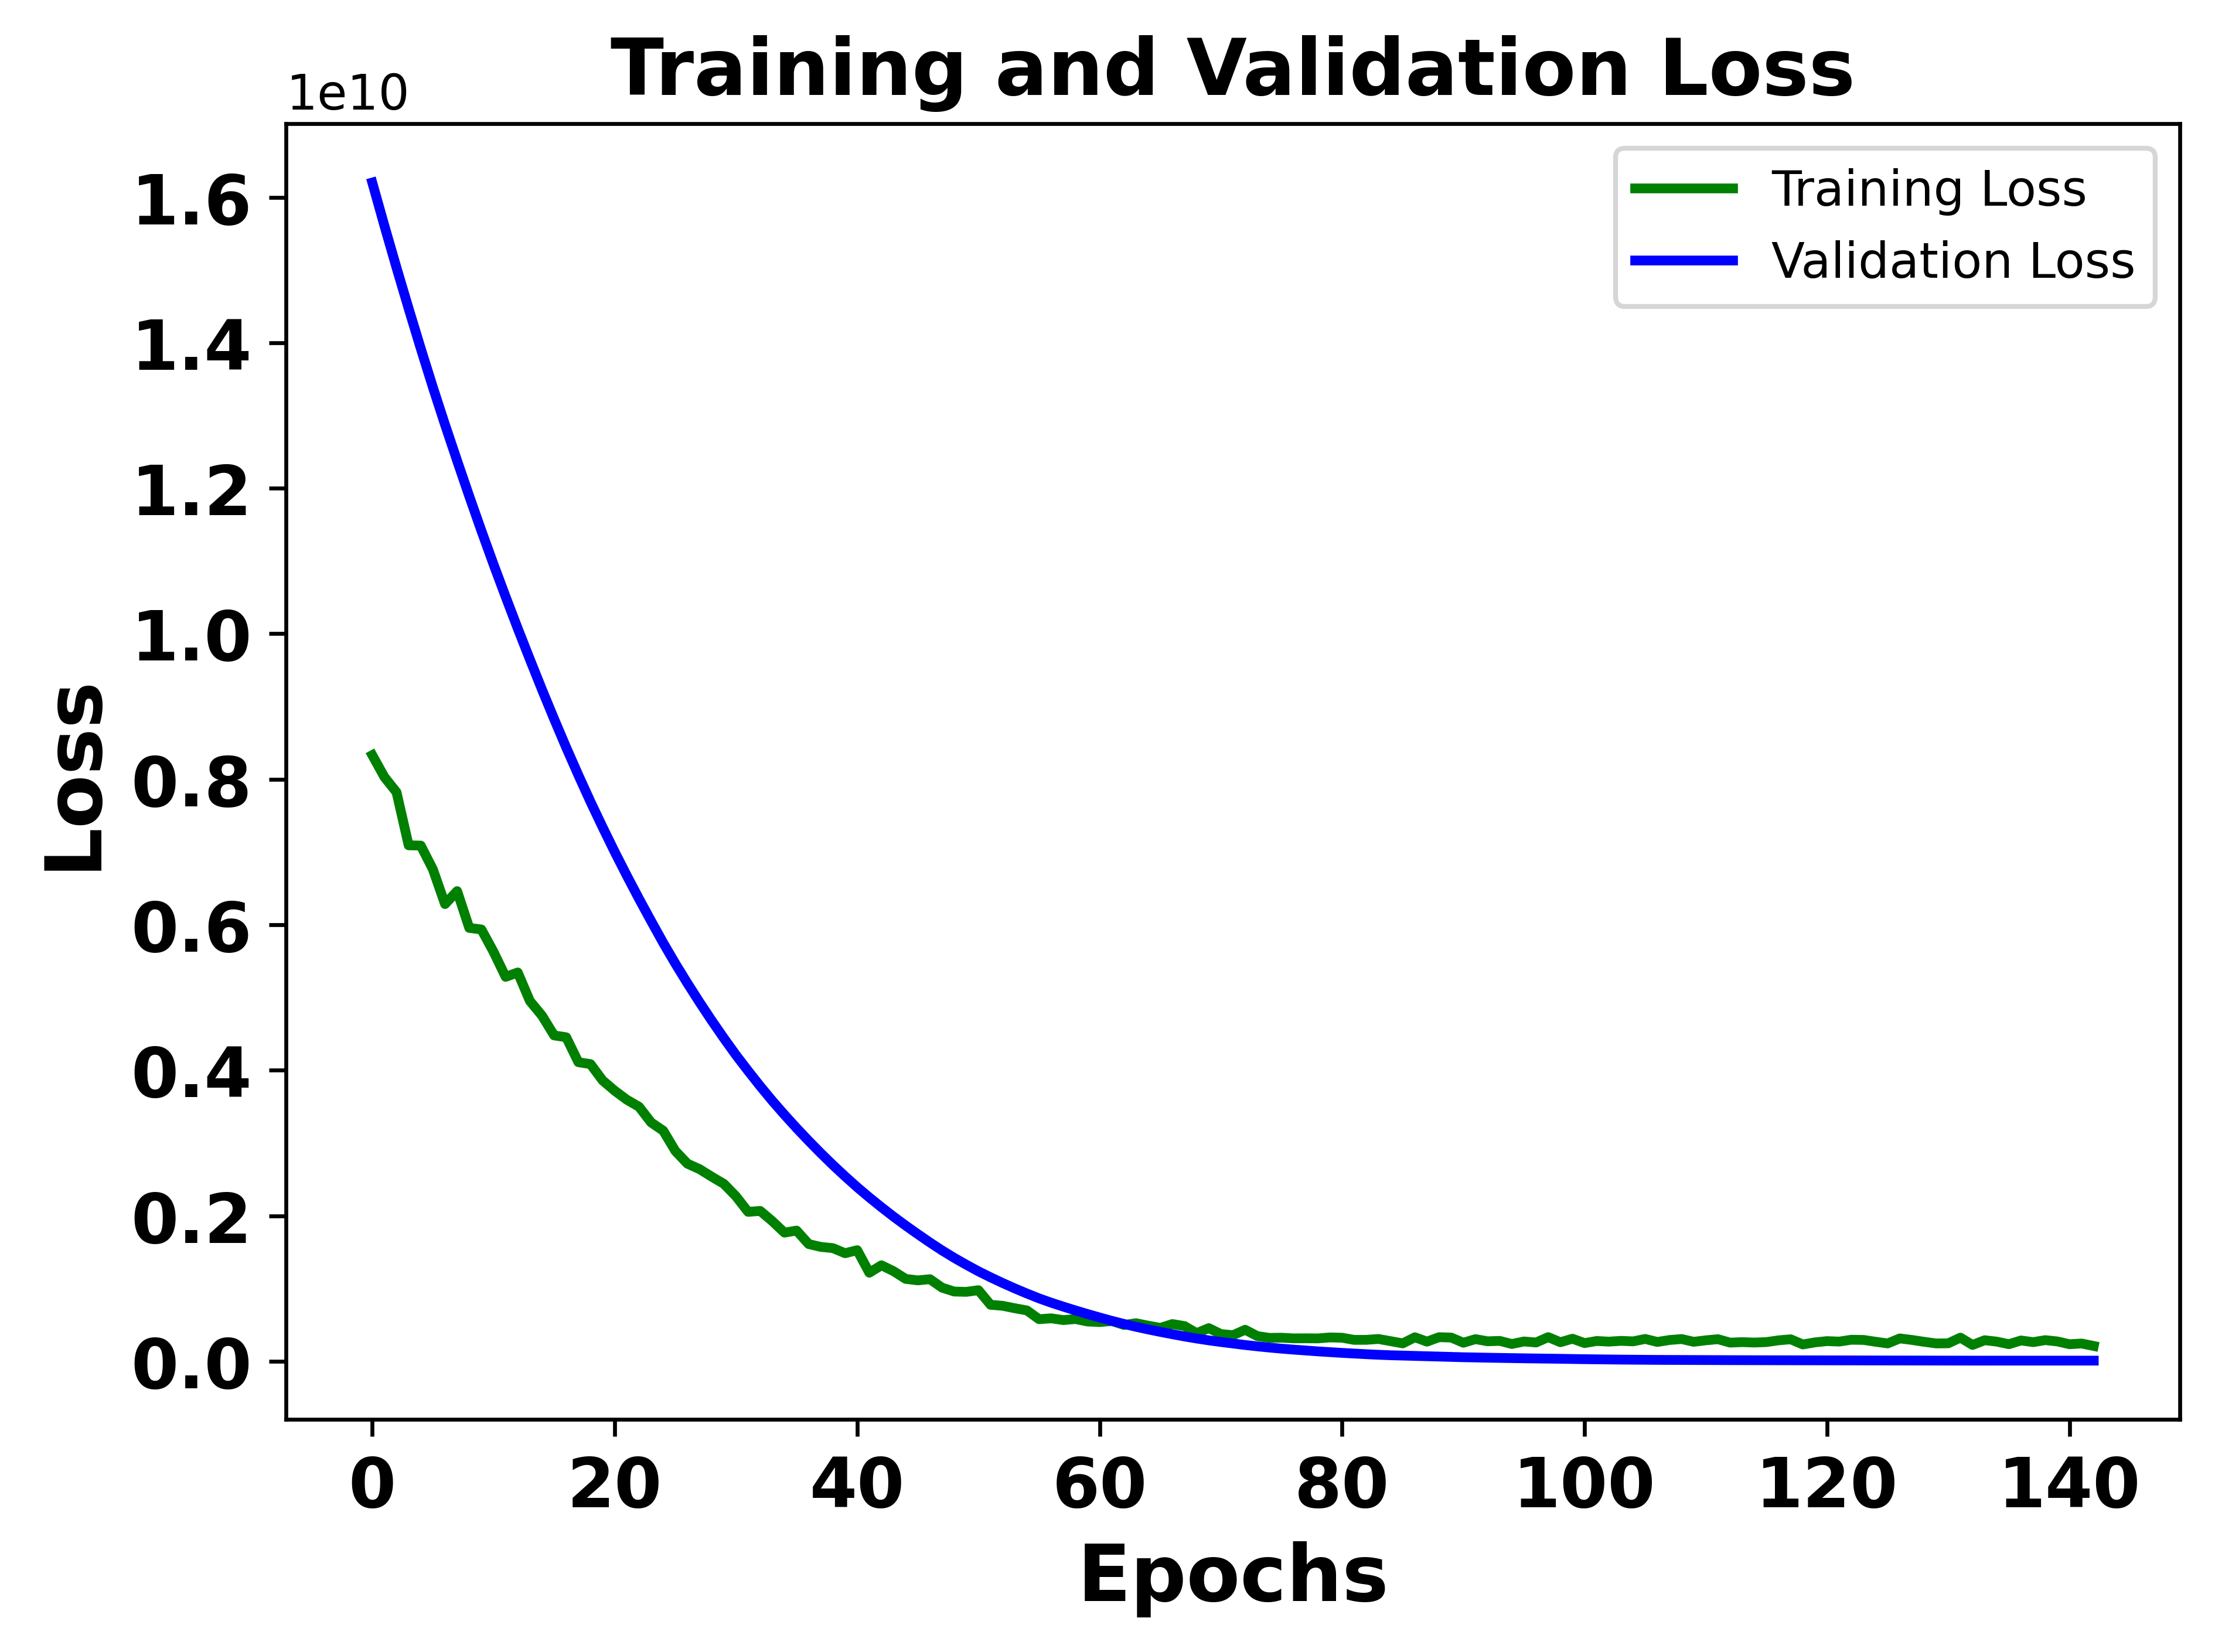

In [20]:
plot_loss(history, "resources/base_model_loss.jpeg")

Evaluamos el modelo en el conjunto de test:

In [21]:
test_loss = model.evaluate(X_test, y_test, verbose=1, return_dict=True)
pprint(test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 12425066.0000 - mean_absolute_error: 2679.7815
{'loss': 12425066.0, 'mean_absolute_error': 2679.781494140625}


Calculamos las métricas de evaluación:

In [22]:
pred_test = model.predict(X_test)
metrics_dict_test = calculate_metrics(y_test, pred_test)
print("\nTest Set Metrics:")
for metric_name, metric_value in metrics_dict_test.items():
    print(f"Score ({metric_name}): {metric_value}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step

Test Set Metrics:
Score (RMSE): 3524.9209102993777
Score (MAPE): 3.1270616218232026
Score (MAE): 2679.781678571428
Score (MSE): 12425067.423865793
Score (sMAPE): 3.122455798959015
Score (RRMSE): 4.139737002856116
Score (Quantile Loss): 1339.890839285714


Guardamos las métricas de evaluación:

In [23]:
df_line = pd.DataFrame({
    "model": "Custom Transformer",
    "mae": metrics_dict_test["MAE"],
    "mape": metrics_dict_test["MAPE"],
    "rmse": metrics_dict_test["RMSE"]
}, index=[0])

df_metrics = pd.concat([df_metrics, df_line], ignore_index=True)

In [24]:
df_metrics

,model,mae,mape,rmse
0,Naive,1735.726500,1.888647,2434.504211
1,"ARIMA(1,1,35)",1891.662281,2.063588,2546.257391
2,"ARIMA(0,1,0)",1735.726500,1.894494,2434.504211
3,Prophet,2582.551322,2.871448,3621.703076
4,XGBoost (ST original),4319.031819,4.609317,5555.304516
5,XGBoost (ST diferenciada),1220.061373,290.783756,1849.183184
6,LSTM,2432.965561,2.645095,3192.781096
7,Custom Transformer,2679.781679,3.127062,3524.920910


Finalmente, graficamos para observar los resultados de la predicción:

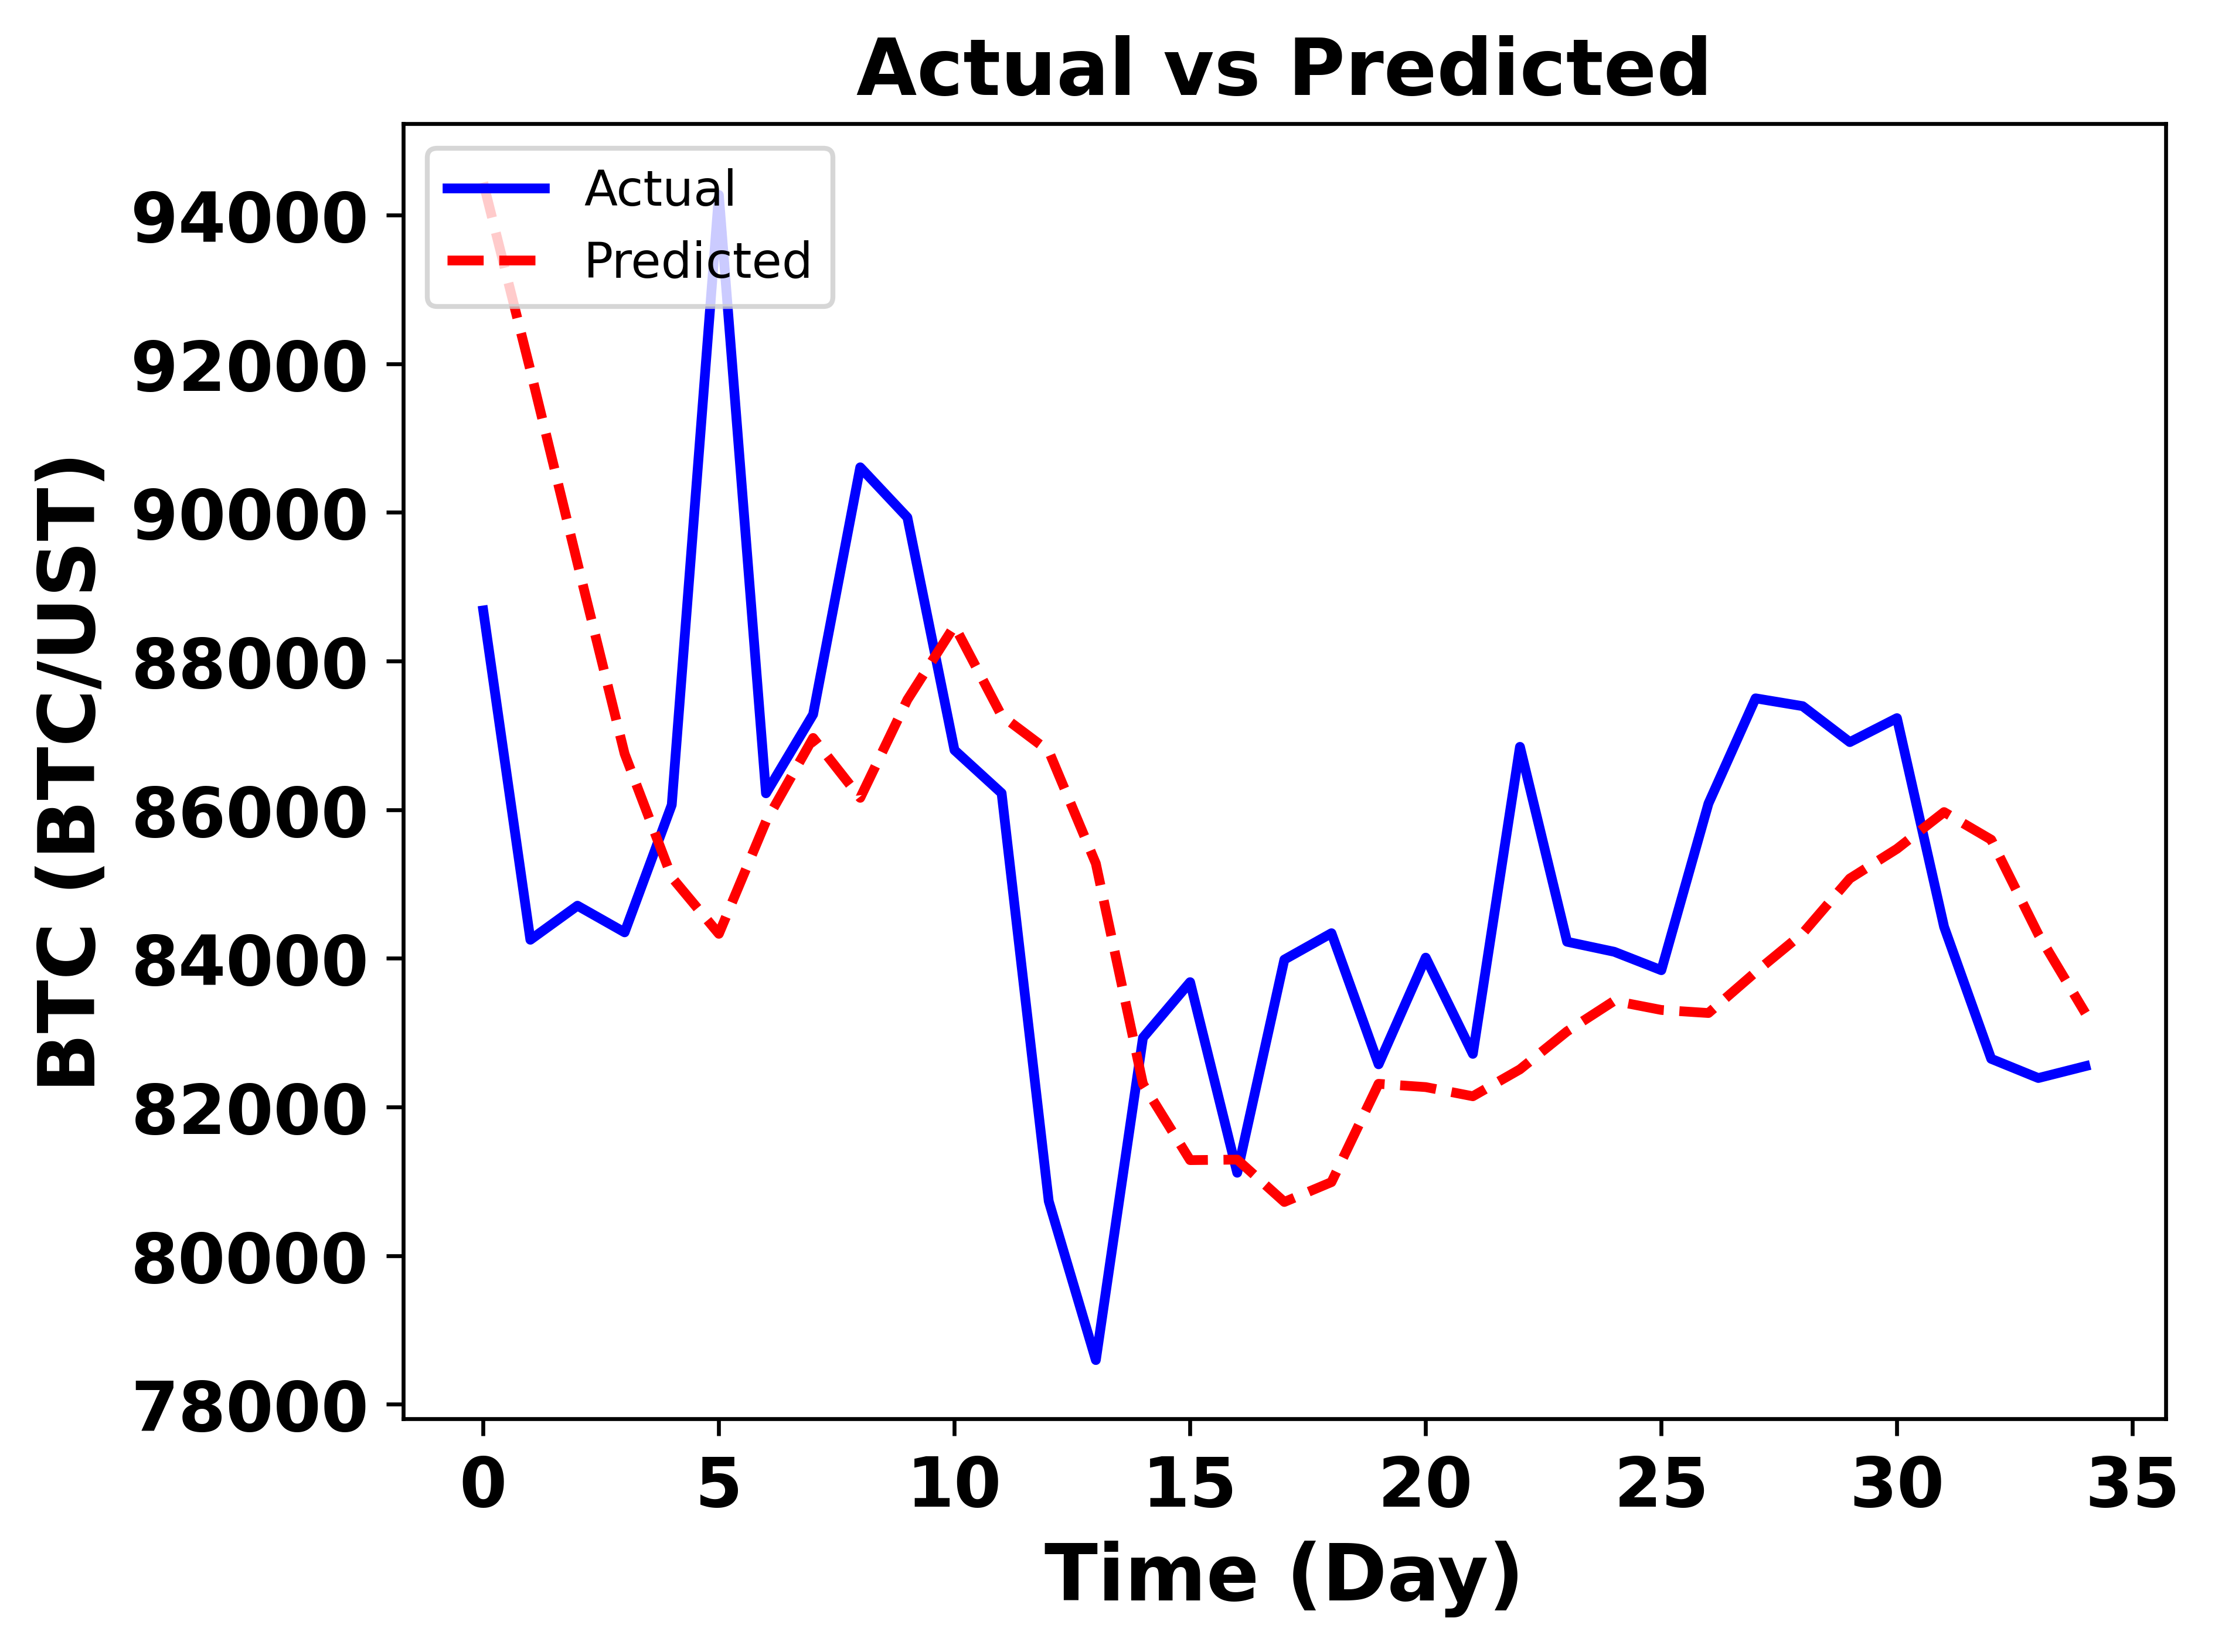

In [25]:
plot_actual_vs_predicted(y_test, pred_test, "resources/base_model_predict.jpeg")

### 3.2. Transformer + positional encoding <a class="anchor" id="section3_2"></a>

- <small><em>[Making new layers and models via subclassing](https://keras.io/guides/making_new_layers_and_models_via_subclassing/)</small></em>

El objetivo de esta sección es explorar la incorporación de un *positional encoding* alternativo al modelo *Transformer* previamente construido. Este enfoque busca mejorar la capacidad del modelo para capturar patrones temporales en los datos de series de tiempo.
Para ello, se define una nueva clase `PositionalEmbedding` que hereda de `Layer` de *Keras*. Esta clase implementa un *positional encoding* basado en la codificación de las posiciones de los datos en la secuencia. La idea es que entrada del modelo tenga una representación única que permita que éste aprenda patrones temporales de manera más efectiva.

Ejemplo básico de implementación de un `Layer` de Keras:

```python
class Linear(keras.layers.Layer):
    def __init__(self, units=32):
        super().__init__()
        self.units = units

    def build(self, input_shape):
        self.w = self.add_weight(
            shape=(input_shape[-1], self.units),
            initializer="random_normal",
            trainable=True,
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="random_normal", trainable=True
        )

    def call(self, inputs):
        return ops.matmul(inputs, self.w) + self.b

    def get_config(self):
        return {"units": self.units}
```

> 💡 <em><font color='IndianRed'>Idea:</font></em> A diferencia de NLP, en donde los tokens son discretos y para estos casos se utiliza la capa `Embedding` de *Keras*, en series de tiempo, los datos son continuos, por lo que para incrustarlos en un espacio de mayor dimensión, probaremos utilizar simplemente una capa `Dense`, en donde el objetivo es que esta capa aprenda a mapear los valores de la serie de tiempo a un espacio dimensional específico (`output_dim`).

Implementación de la clase `PositionalEmbedding`:

In [26]:
class PositionalEmbedding(Layer):
    """
    Capa de embedding posicional para series de tiempo.

    Args:
        output_dim (int): Dimensión de salida de los embeddings.
        seq_length (int): Longitud de la secuencia de entrada.
        **kwargs: Argumentos adicionales para la clase base Layer.
    """
    def __init__(self, output_dim: int, seq_length: int, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.seq_length = seq_length

    def build(self) -> None:
        self.token_embeddings = Dense(self.output_dim, activation=None)
        self.position_embeddings = Embedding(input_dim=self.seq_length, output_dim=self.output_dim)

    def call(self, inputs):
        positions = np.arange(self.seq_length) # Shape: (batch_size, seq_length) -> (batch_size, seq_length)
        embedded_positions = self.position_embeddings(positions) # Shape: (batch_size, seq_length) -> (batch_size, seq_length, output_dim)
        embedded_tokens = self.token_embeddings(inputs) # Shape: (batch_size, seq_length) -> (batch_size, seq_length, output_dim)
        # Sumar los embeddings posicionales y los embeddings de los tokens
        return embedded_tokens + embedded_positions # Shape: (batch_size, seq_length, output_dim) -> (batch_size, seq_length, output_dim)

    def get_config(self) -> dict:
        config = super().get_config()
        config.update(
            {
                "input_shape": self.input_shape,
                "output_dim": self.output_dim,
            }
        )
        return config

Realizamos un test de verificación:

```python
    inp = Input(shape=(WINDOW_SIZE, 1))
    out = PositionalEmbedding(16)(inp)
    test_model = Model(inputs=inp, outputs=out)
    output = test_model.predict(keras.random.normal(shape=(WINDOW_SIZE, 1)))
```

In [27]:
x = keras.random.normal(shape=(WINDOW_SIZE, 1))
y = PositionalEmbedding(output_dim=8, seq_length=WINDOW_SIZE)(x)
y.shape

TensorShape([5, 8])

Modificamos la función `build_model` para incorporar la nueva capa `PositionalEmbedding`, creando una nueva función auxiliar `build_model_with_positional_embedding`:

In [28]:
def build_model_with_embeddings(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    num_transformer_blocks,
    mlp_units,
    seq_length,
    dropout=0,
    mlp_dropout=0,
    embedding_dim=None,
):
    """
    Construye un modelo Transformer para series de tiempo que incorpora una capa de embedding posicional.

    Args:
        input_shape (tuple): Forma de la entrada (longitud de la secuencia, número de características).
        head_size (int): Dimensión de cada cabeza de atención en MultiHeadAttention.
        num_heads (int): Número de cabezas de atención.
        ff_dim (int): Dimensión de la red feed-forward interna de cada bloque Transformer.
        num_transformer_blocks (int): Número de bloques codificadores Transformer a apilar.
        mlp_units (list): Lista con el número de unidades para cada capa densa (MLP) posterior.
        seq_length (int): Longitud de la secuencia de entrada.
        dropout (float, opcional): Tasa de dropout en los bloques Transformer. Por defecto 0.
        mlp_dropout (float, opcional): Tasa de dropout en las capas MLP. Por defecto 0.
        embedding_dim (int, opcional): Dimensión de salida de la capa de embedding. Si no se especifica, se utiliza `head_size`.

    Returns:
        keras.Model: Modelo Keras listo para compilar y entrenar.
    """
    inputs = Input(shape=input_shape) # Shape: (batch_size, sequence_length, num_features) -> (batch_size, sequence_length, num_features)
    x = inputs

    # Determinar la dimensión de embedding:
    # Si embedding_dim no se especifica, usa el `head_size` para que sea consistente con la dimensión de entrada del Transformer.
    if embedding_dim is None:
        embedding_dim = head_size

    x = PositionalEmbedding(output_dim=embedding_dim, seq_length=seq_length)(x) # Shape: (batch_size, sequence_length, num_features) -> (batch_size, sequence_length, embedding_dim)

    # Apilar bloques de codificador Transformer
    for _ in range(num_transformer_blocks):
        x = transformer_block(x, head_size, num_heads, ff_dim, dropout) # Shape: (batch_size, sequence_length, embedding_dim) -> (batch_size, sequence_length, embedding_dim)

    x = GlobalAveragePooling1D()(x) # Shape: (batch_size, sequence_length, embedding_dim) -> (batch_size, embedding_dim)

    # Capa MLP
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x) # Shape: (batch_size, embedding_dim) -> (batch_size, dim)
        x = Dropout(mlp_dropout)(x) # Shape: (batch_size, dim) -> (batch_size, dim)

    outputs = Dense(1)(x) # Shape: (batch_size, dim) -> (batch_size, 1)

    return Model(inputs, outputs)

Creamos el "nuevo" modelo:

In [29]:
input_shape = X_train.shape[1:]
model = build_model_with_embeddings(
    input_shape,
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    seq_length=WINDOW_SIZE,
    dropout=0.25,
    mlp_dropout=0.4,
    embedding_dim=EMMBEDDING_DIM
)

Mostramos el resumen:

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 5, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 5, 8)      │         56 │ input_layer_1[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 8)      │         16 │ positional_embed… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 8)      │     35,848 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 5, 8)      │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 5, 8)      │          0 │ dropout_14[0][0], │
│                     │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 8)      │         16 │ add_8[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 5, 4)      │         36 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 5, 4)      │          0 │ conv1d_8[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 5, 8)      │         40 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 5, 8)      │          0 │ conv1d_9[0][0],   │
│                     │                   │            │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 8)      │         16 │ add_9[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 5, 8)      │     35,848 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_17          │ (None, 5, 8)      │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 5, 8)      │          0 │ dropout_17[0][0], │
│                     │                   │            │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 5, 8)      │         16 │ add_10[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 5, 4)      │         36 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 5, 4)      │          0 │ conv1d_10[0][0] 

 Total params: 145,161 (567.04 KB)

 Trainable params: 145,161 (567.04 KB)

 Non-trainable params: 0 (0.00 B)

Finalmente, compilamos el modelo y lo entrenamos:

In [31]:
model.compile(
    loss=MeanSquaredError(), optimizer=Adam(learning_rate=1e-4), metrics=[MeanAbsoluteError()] 
)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=500, batch_size=64, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)])

Epoch 1/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - loss: 5588456960.0000 - mean_absolute_error: 73490.8438 - val_loss: 11337164800.0000 - val_mean_absolute_error: 106407.9844
Epoch 2/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5300493824.0000 - mean_absolute_error: 71636.9375 - val_loss: 10994637824.0000 - val_mean_absolute_error: 104787.3906
Epoch 3/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 5304005632.0000 - mean_absolute_error: 71755.5312 - val_loss: 10660461568.0000 - val_mean_absolute_error: 103181.7812
Epoch 4/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 5186984448.0000 - mean_absolute_error: 70722.2500 - val_loss: 10331286528.0000 - val_mean_absolute_error: 101575.3828
Epoch 5/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 4994595840.0000 - mean_absolute_error: 69447.0391 - val_loss: 10007791616.0000 - val_mean_absolute_error: 99971.5625
Epoch 6/500
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4870999552.0000 - mean_absolute_error: 68431.6875 - val_loss: 

Mostramos el progreso del entrenamiento:

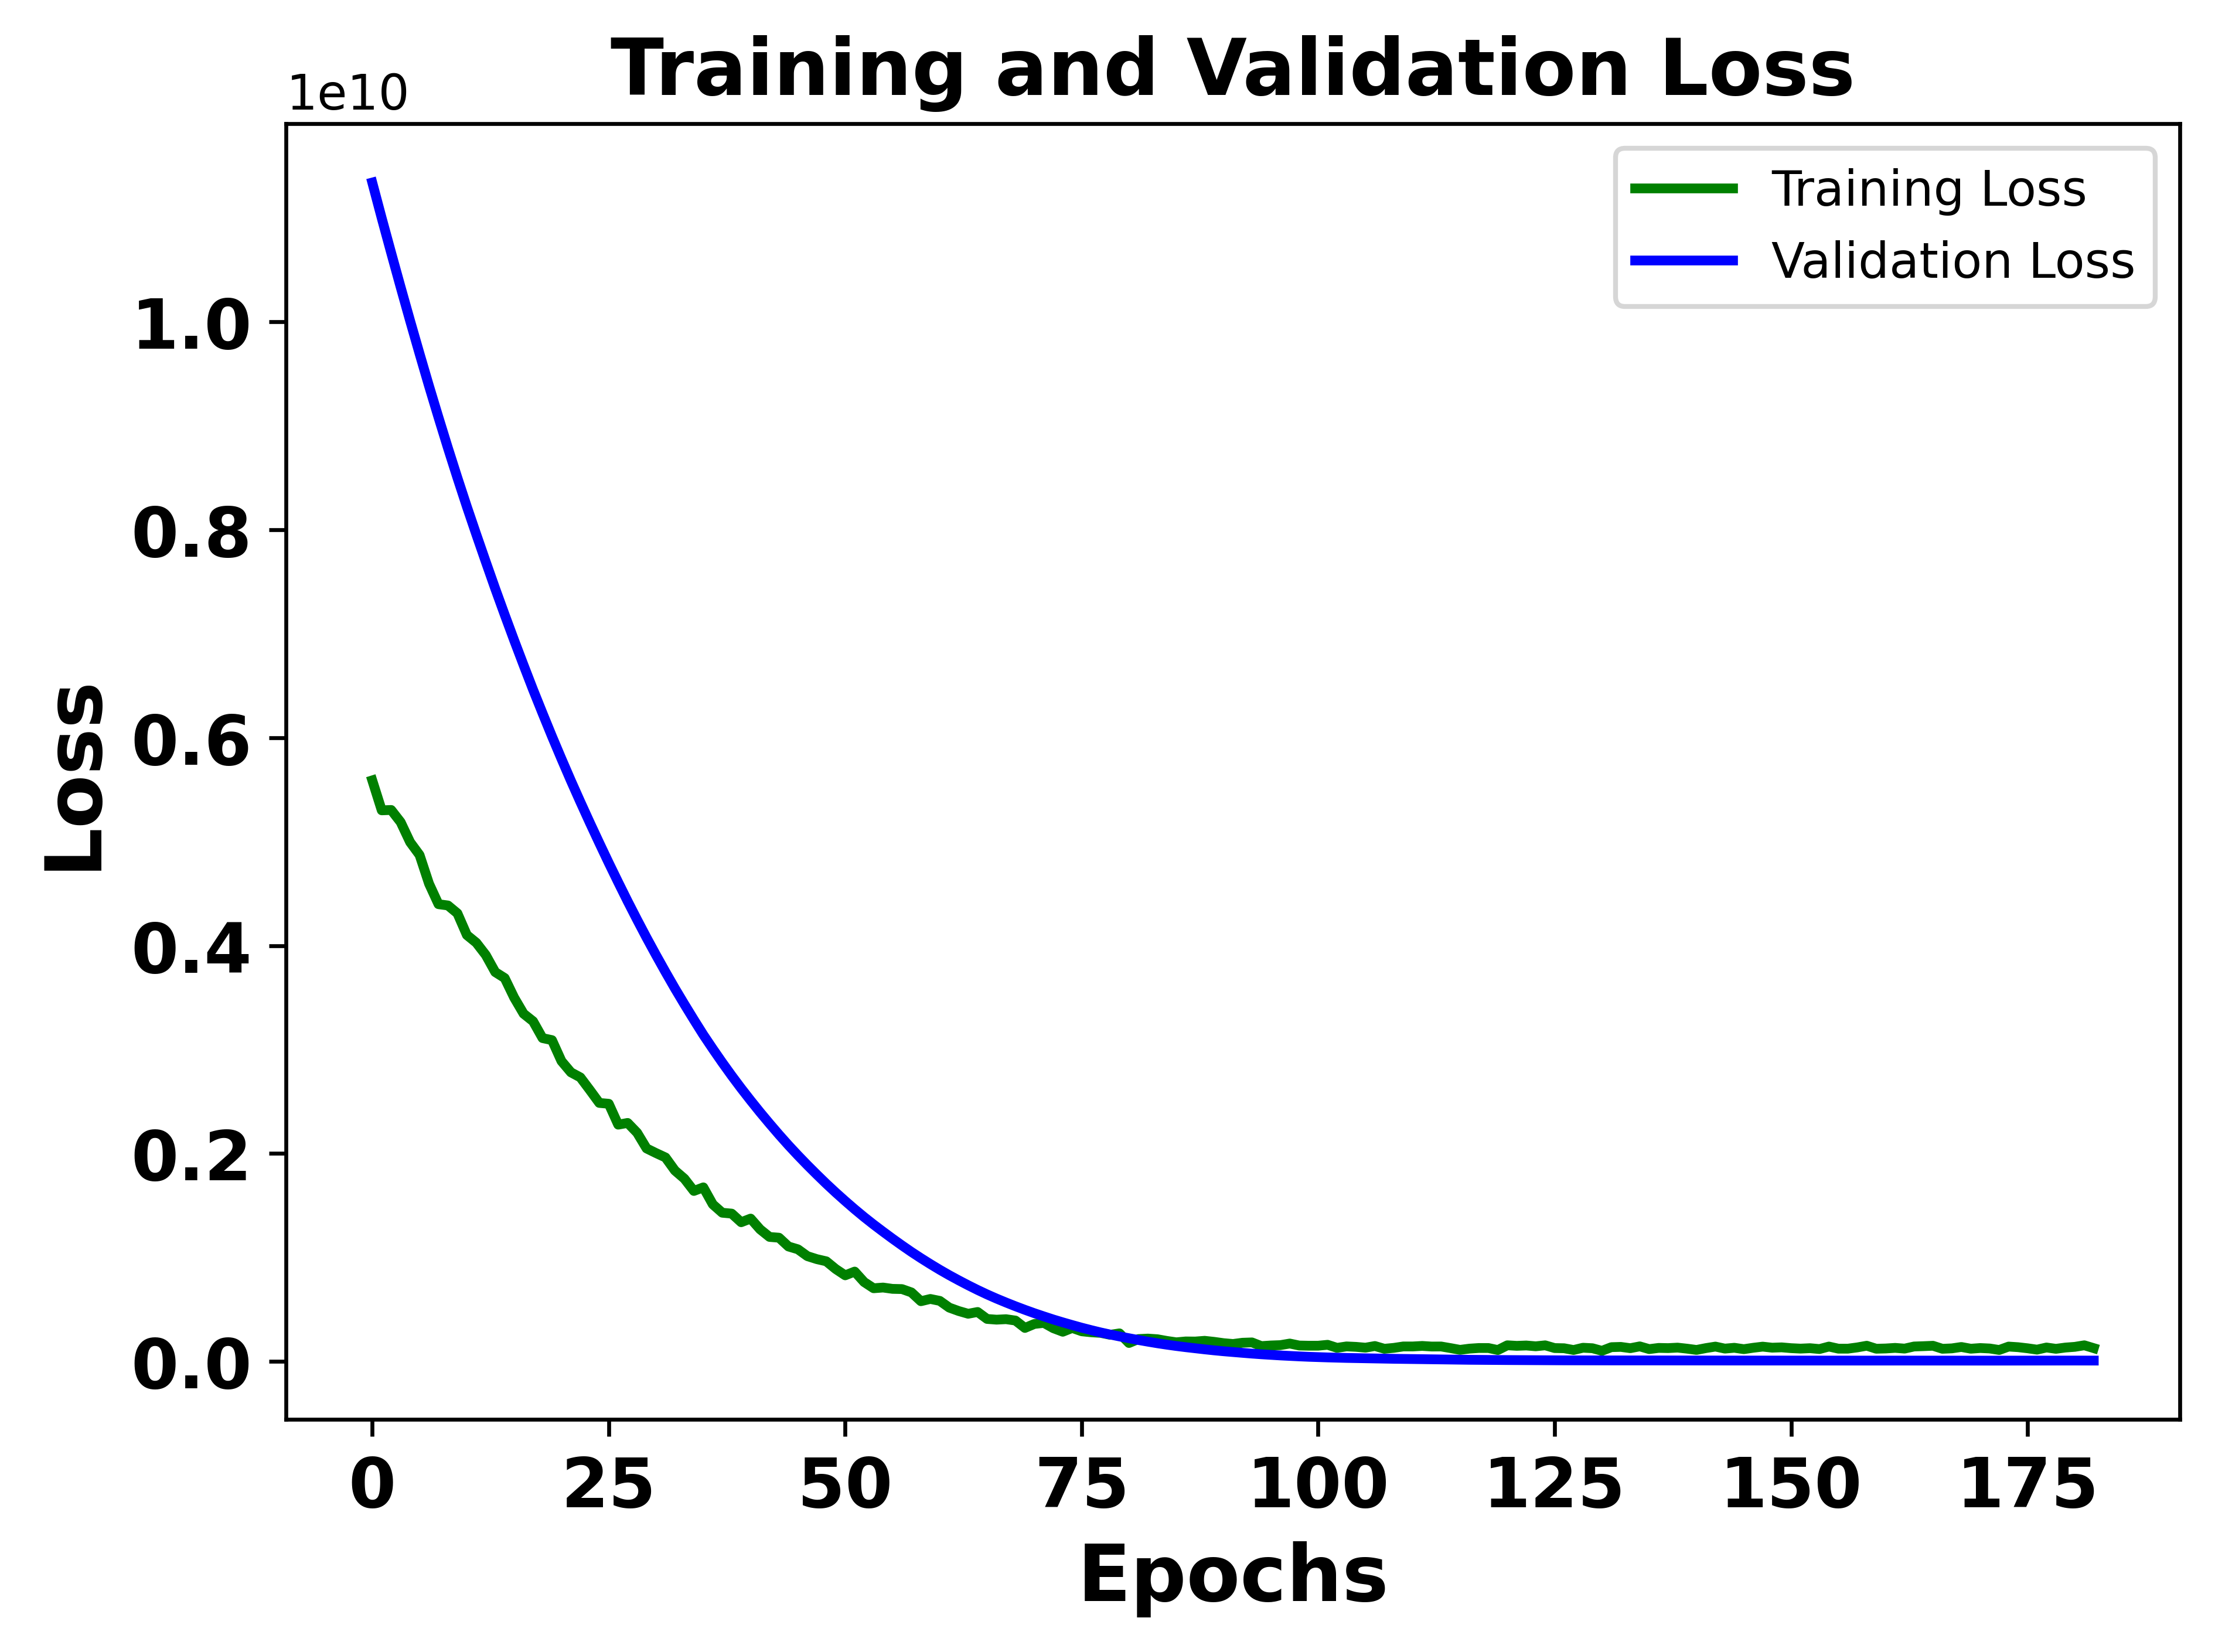

In [32]:
plot_loss(history, "resources/embedding_model_loss.jpeg")

Evaluamos el modelo en el conjunto de test:

In [33]:
test_loss = model.evaluate(X_test, y_test, verbose=1, return_dict=True)
pprint(test_loss)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 13589221.0000 - mean_absolute_error: 2773.6184
{'loss': 13589221.0, 'mean_absolute_error': 2773.618408203125}


Calculamos las métricas de evaluación:

In [34]:
pred_test = model.predict(X_test)
metrics_dict_test = calculate_metrics(y_test, pred_test)
print("\nTest Set Metrics:")
for metric_name, metric_value in metrics_dict_test.items():
    print(f"Score ({metric_name}): {metric_value}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 273ms/step

Test Set Metrics:
Score (RMSE): 3686.356119933579
Score (MAPE): 3.2459650457078535
Score (MAE): 2773.6186339285705
Score (MSE): 13589221.442971753
Score (sMAPE): 3.221968999051484
Score (RRMSE): 4.329329713697897
Score (Quantile Loss): 1386.8093169642852


Guardamos las métricas de evaluación en el diccionario:

In [35]:
df_line = pd.DataFrame({
    "model": "Custom Transformer Embedding",
    "mae": metrics_dict_test["MAE"],
    "mape": metrics_dict_test["MAPE"],
    "rmse": metrics_dict_test["RMSE"]
}, index=[0])

df_metrics = pd.concat([df_metrics, df_line], ignore_index=True)
df_metrics

,model,mae,mape,rmse
0,Naive,1735.726500,1.888647,2434.504211
1,"ARIMA(1,1,35)",1891.662281,2.063588,2546.257391
2,"ARIMA(0,1,0)",1735.726500,1.894494,2434.504211
3,Prophet,2582.551322,2.871448,3621.703076
4,XGBoost (ST original),4319.031819,4.609317,5555.304516
5,XGBoost (ST diferenciada),1220.061373,290.783756,1849.183184
6,LSTM,2432.965561,2.645095,3192.781096
7,Custom Transformer,2679.781679,3.127062,3524.920910
8,Custom Transformer Embedding,2773.618634,3.245965,3686.356120


Realizamos la predicción y graficamos los resultados:

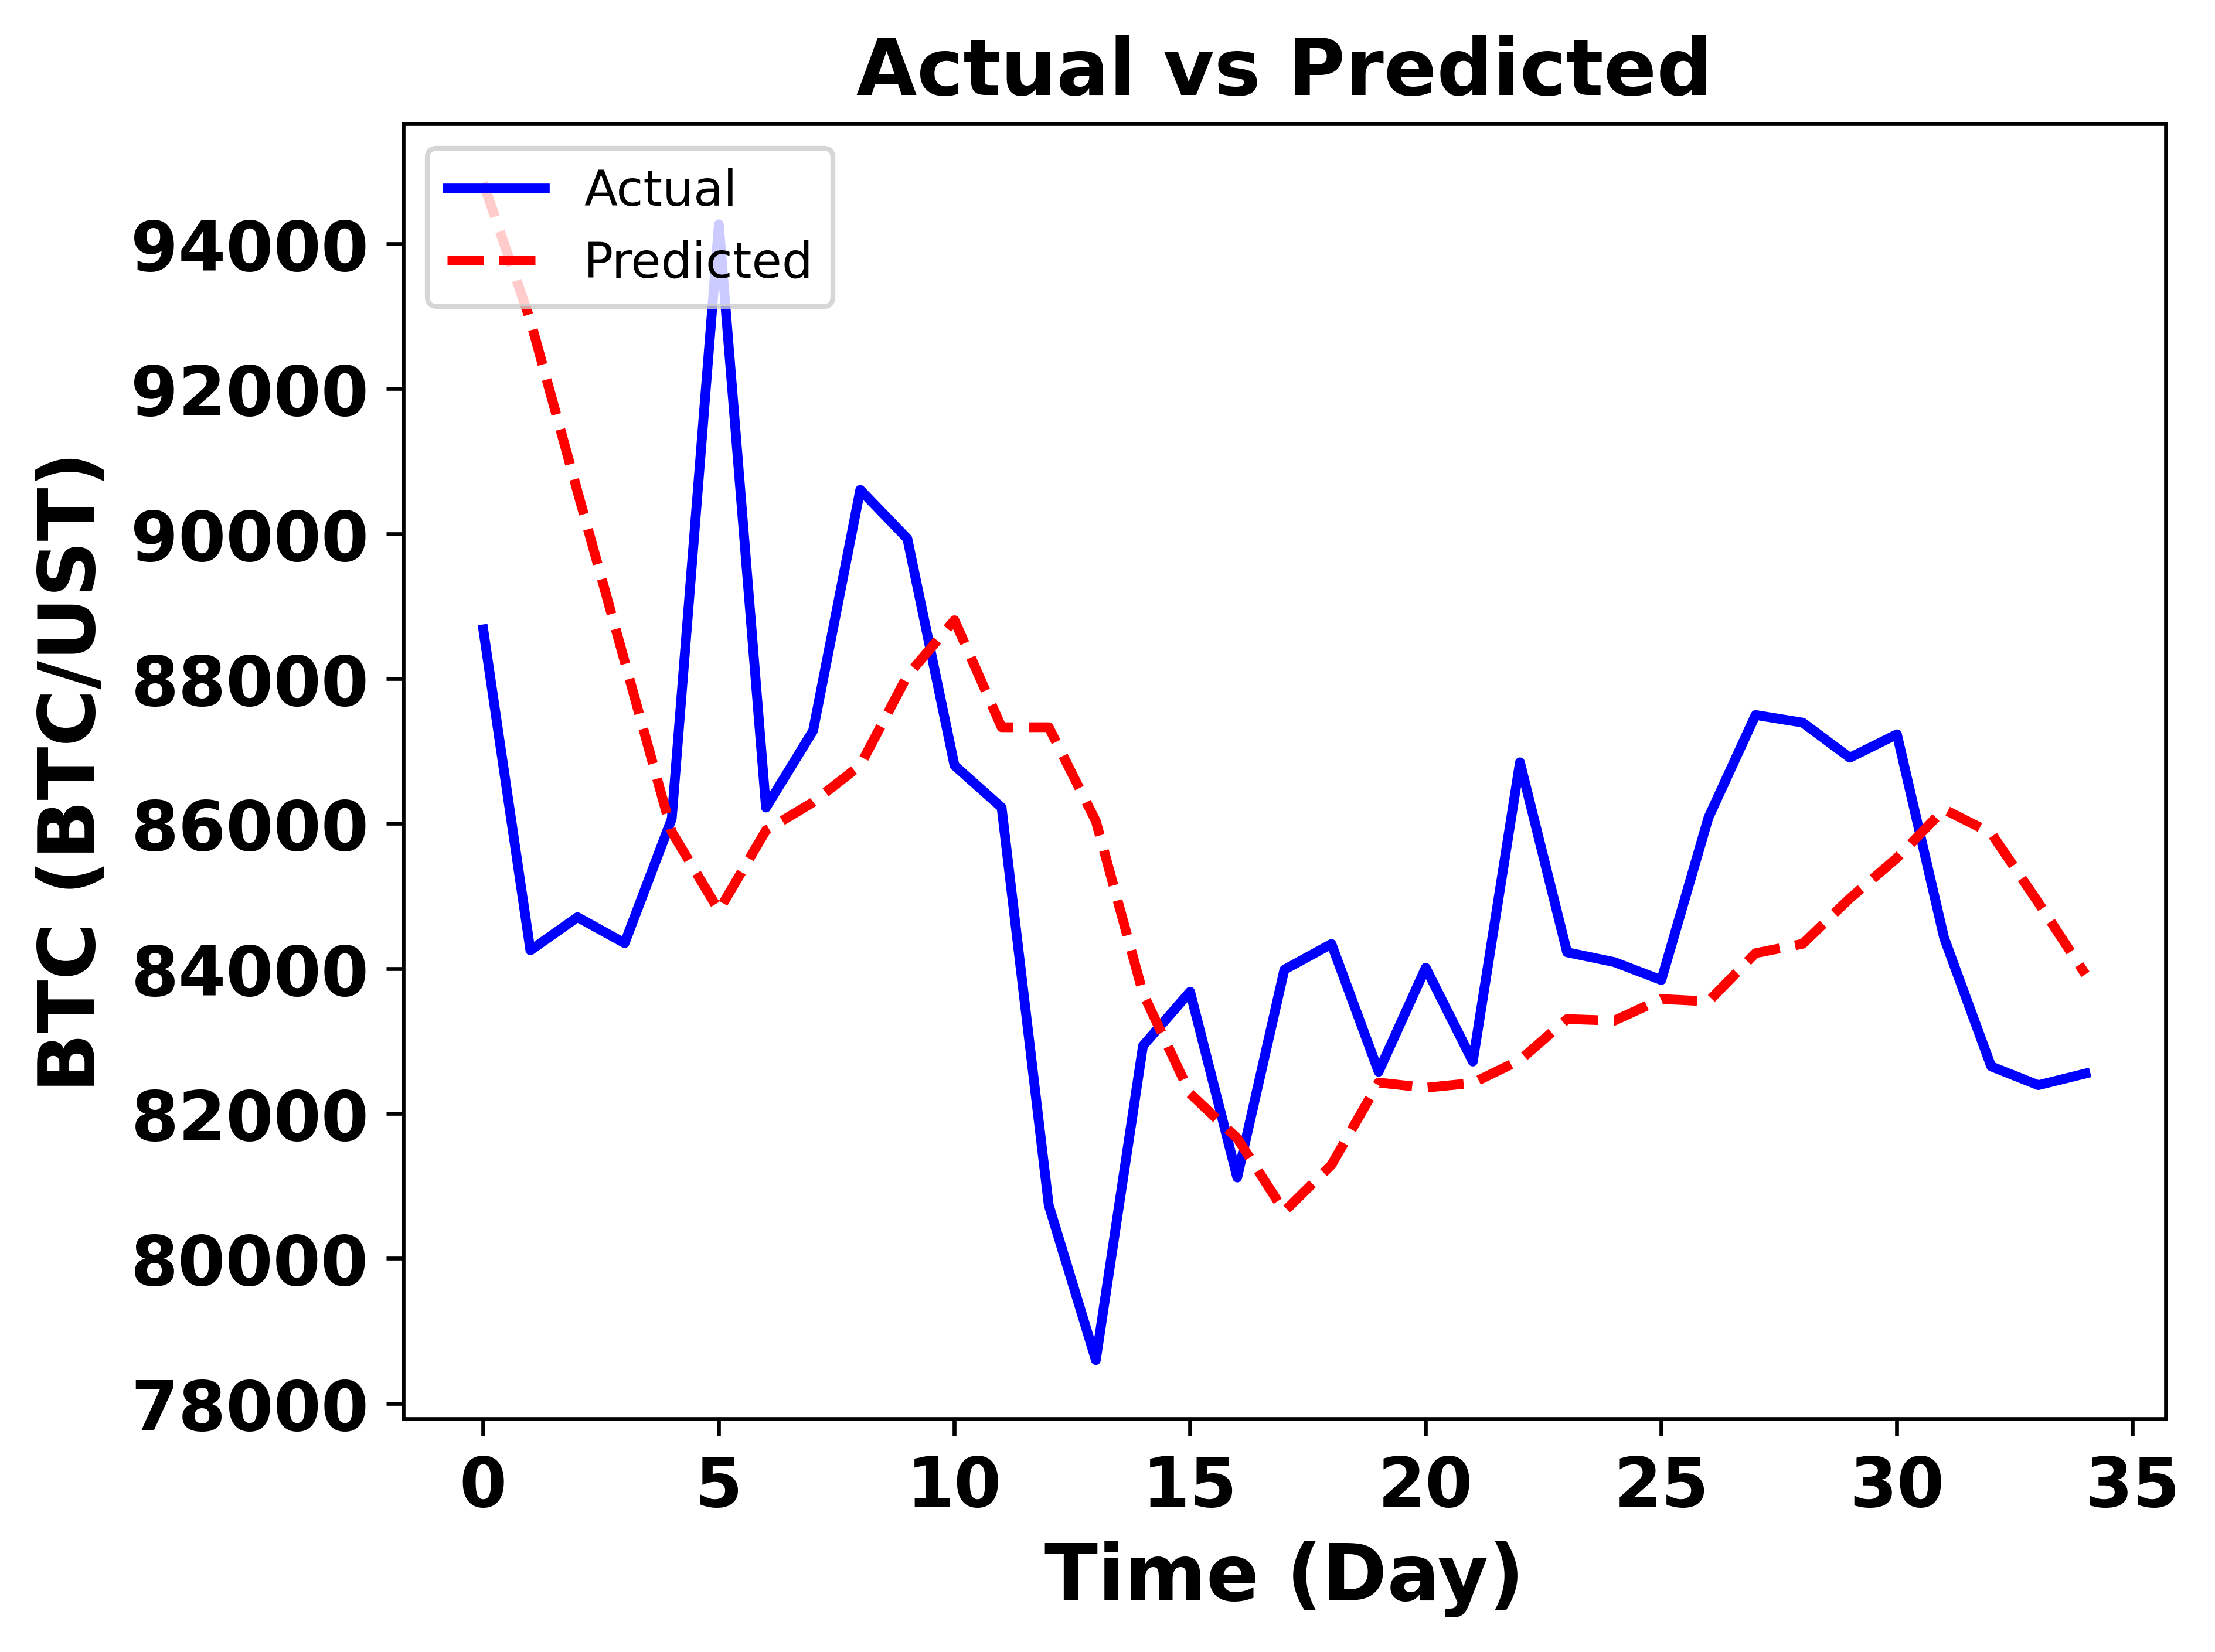

In [36]:
plot_actual_vs_predicted(y_test, pred_test, "resources/embbeding_model_predict.jpeg")

## 4. Estado del arte <a class="anchor" id="chapter4"></a>

### 4.1. Caso de uso: TimesFM <a class="anchor" id="section_4_1"></a>

En esta sección, se presenta el análisis de la serie que se viene trabajando pero con el modelo *TimesFM*. Se utiliza `TimesFmModelForPrediction` de *HuggingFace*.

`TimesFmModelForPrediction` espera:

- $\rightarrow$ `past_values`: Una lista de tensores, donde cada tensor representa una serie temporal individual. *El modelo está diseñado para pronosticar múltiples series temporales a la vez, por lo que past_values es una lista.* Cada tensor en la lista debe tener la forma `(sequence_length,)`.
- $\rightarrow$ `freq`: Una lista (o un tensor) de índices de frecuencia, uno para cada serie temporal en past_values. `TimesFM` utiliza estas frecuencias para adaptar su codificación posicional y otros aspectos del modelo a la periodicidad de los datos. Los valores típicos son:
    - $0$: Alta frecuencia (ej. diario, horario).
    - $1$: Frecuencia media (ej. semanal, mensual).
    - $2$: Baja frecuencia (ej. trimestral, anual).

<!-- TODO: Compeltar con más parámetros -->

En el ejemplo de *HuggingFace*, se utilizan estos datos como prueba:
```python
# Create dummy inputs
forecast_input = [
    np.sin(np.linspace(0, 20, 100)),
    np.sin(np.linspace(0, 20, 200)),
    np.sin(np.linspace(0, 20, 400)),
]
frequency_input = [0, 1, 2]

# Convert inputs to sequence of tensors
forecast_input_tensor = [
    torch.tensor(ts, dtype=torch.bfloat16).to("cuda" if torch.cuda.is_available() else "cpu") for ts in forecast_input
]
frequency_input_tensor = torch.tensor(frequency_input, dtype=torch.long).to(
    "cuda" if torch.cuda.is_available() else "cpu"
)
```

En donde podemos observar que `forecast_input` es una lista de series temporales, y `frequency_input` es una lista de frecuencias asociadas a cada serie temporal.
Para este caso, el conjunto `spots_train` y `spots_test` ya tienen la forma adecuada (serie univariada), por lo que simplemente debemos crear la lista de tensores y las frecuencias asociadas. A diferencia de los casos anteriores, en donde se formateaba el conjunto para una ventana de tiempo.

Convertimos los datos a tensores:

In [37]:
forecast_input = np.array(spots_train).flatten()

Creamos los tensores y lo tiramos a la GPU si está disponible:

In [38]:
forecast_input_tensor = [torch.tensor(forecast_input, dtype=torch.bfloat16).to(DEVICE)]
frequency_input_tensor = torch.tensor([0], dtype=torch.long).to(DEVICE)
print(f"Input tensor shape: {forecast_input_tensor[0].shape}")
print(f"Frequency tensor shape: {frequency_input_tensor.shape}")

Input tensor shape: torch.Size([356])
Frequency tensor shape: torch.Size([1])


Cargamos el modelo:

In [39]:
model = TimesFmModelForPrediction.from_pretrained(
    "google/timesfm-2.0-500m-pytorch",
    torch_dtype=torch.bfloat16,
    attn_implementation="sdpa",
    device_map=DEVICE,
)

config = model.config

Imprimimos el resumen del modelo:

In [40]:
print(model)

TimesFmModelForPrediction(
  (decoder): TimesFmModel(
    (input_ff_layer): TimesFmResidualBlock(
      (input_layer): Linear(in_features=64, out_features=1280, bias=True)
      (activation): SiLU()
      (output_layer): Linear(in_features=1280, out_features=1280, bias=True)
      (residual_layer): Linear(in_features=64, out_features=1280, bias=True)
    )
    (freq_emb): Embedding(3, 1280)
    (layers): ModuleList(
      (0-49): 50 x TimesFmDecoderLayer(
        (self_attn): TimesFmAttention(
          (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (o_proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (mlp): TimesFmMLP(
          (gate_proj): Linear(in_features=1280, out_features=1280, bias=True)
          (down_proj): Linear(in_features=1280, out_features=1280, bias=True)
        

Mostramos la configuración del modelo:

In [41]:
print(config)

TimesFmConfig {
  "architectures": [
    "TimesFmModelForPrediction"
  ],
  "attention_dropout": 0.0,
  "context_length": 2048,
  "freq_size": 3,
  "head_dim": 80,
  "hidden_size": 1280,
  "horizon_length": 128,
  "initializer_range": 0.02,
  "intermediate_size": 1280,
  "max_timescale": 10000,
  "min_timescale": 1,
  "model_type": "timesfm",
  "num_attention_heads": 16,
  "num_hidden_layers": 50,
  "pad_val": 1123581321.0,
  "patch_length": 32,
  "quantiles": [
    0.1,
    0.2,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.8,
    0.9
  ],
  "rms_norm_eps": 1e-06,
  "tolerance": 1e-06,
  "torch_dtype": "bfloat16",
  "transformers_version": "4.52.4",
  "use_positional_embedding": false
}



> 💡 <em><font color='IndianRed'>Idea:</font></em> Observamos que el modelo tiene un horizonte de predicción de 128 pasos, por lo que está contemplado nuestro conjunto de test, que tiene cerca de 40 pasos (dias): 

In [42]:
assert config.horizon_length > len(spots_test)

Realizamos la predicción:

In [43]:
# Get predictions from the pre-trained model 
with torch.no_grad():
    outputs = model(past_values=forecast_input_tensor, freq=frequency_input_tensor, return_dict=True)
    point_forecast_conv = outputs.mean_predictions.float().cpu().numpy()
    quantile_forecast_conv = outputs.full_predictions.float().cpu().numpy()

# Print the shape of the predictions
print("Point Forecast Shape:", point_forecast_conv.shape)
print("Quantile Forecast Shape:", quantile_forecast_conv.shape)

Point Forecast Shape: (1, 128)
Quantile Forecast Shape: (1, 128, 10)


Finalmente, truncamos la predicción a los primeros 40 pasos y procesamos los resultados:

In [44]:
y_true = np.array(spots_test).flatten()
pred_test = point_forecast_conv.flatten()[:len(y_true)]

Calculamos las métricas de evaluación:

In [45]:
metrics_dict_test = calculate_metrics(y_true, pred_test)
print("\nTest Set Metrics:")
for metric_name, metric_value in metrics_dict_test.items():
    print(f"Score ({metric_name}): {metric_value}")


Test Set Metrics:
Score (RMSE): 3870.8257111206262
Score (MAPE): 3.819422342604954
Score (MAE): 3279.7782500000003
Score (MSE): 14983291.6858725
Score (sMAPE): 3.777163122355528
Score (RRMSE): 4.476180061450597
Score (Quantile Loss): 1639.8891250000001


Guardamos las métricas de evaluación en el diccionario:

In [46]:
df_line = pd.DataFrame({
    "model": "TimesFM",
    "mae": metrics_dict_test["MAE"],
    "mape": metrics_dict_test["MAPE"],
    "rmse": metrics_dict_test["RMSE"]
}, index=[0])

df_metrics = pd.concat([df_metrics, df_line], ignore_index=True)
df_metrics

,model,mae,mape,rmse
0,Naive,1735.726500,1.888647,2434.504211
1,"ARIMA(1,1,35)",1891.662281,2.063588,2546.257391
2,"ARIMA(0,1,0)",1735.726500,1.894494,2434.504211
3,Prophet,2582.551322,2.871448,3621.703076
4,XGBoost (ST original),4319.031819,4.609317,5555.304516
5,XGBoost (ST diferenciada),1220.061373,290.783756,1849.183184
6,LSTM,2432.965561,2.645095,3192.781096
7,Custom Transformer,2679.781679,3.127062,3524.920910
8,Custom Transformer Embedding,2773.618634,3.245965,3686.356120
9,TimesFM,3279.778250,3.819422,3870.825711


Graficamos los resultados:

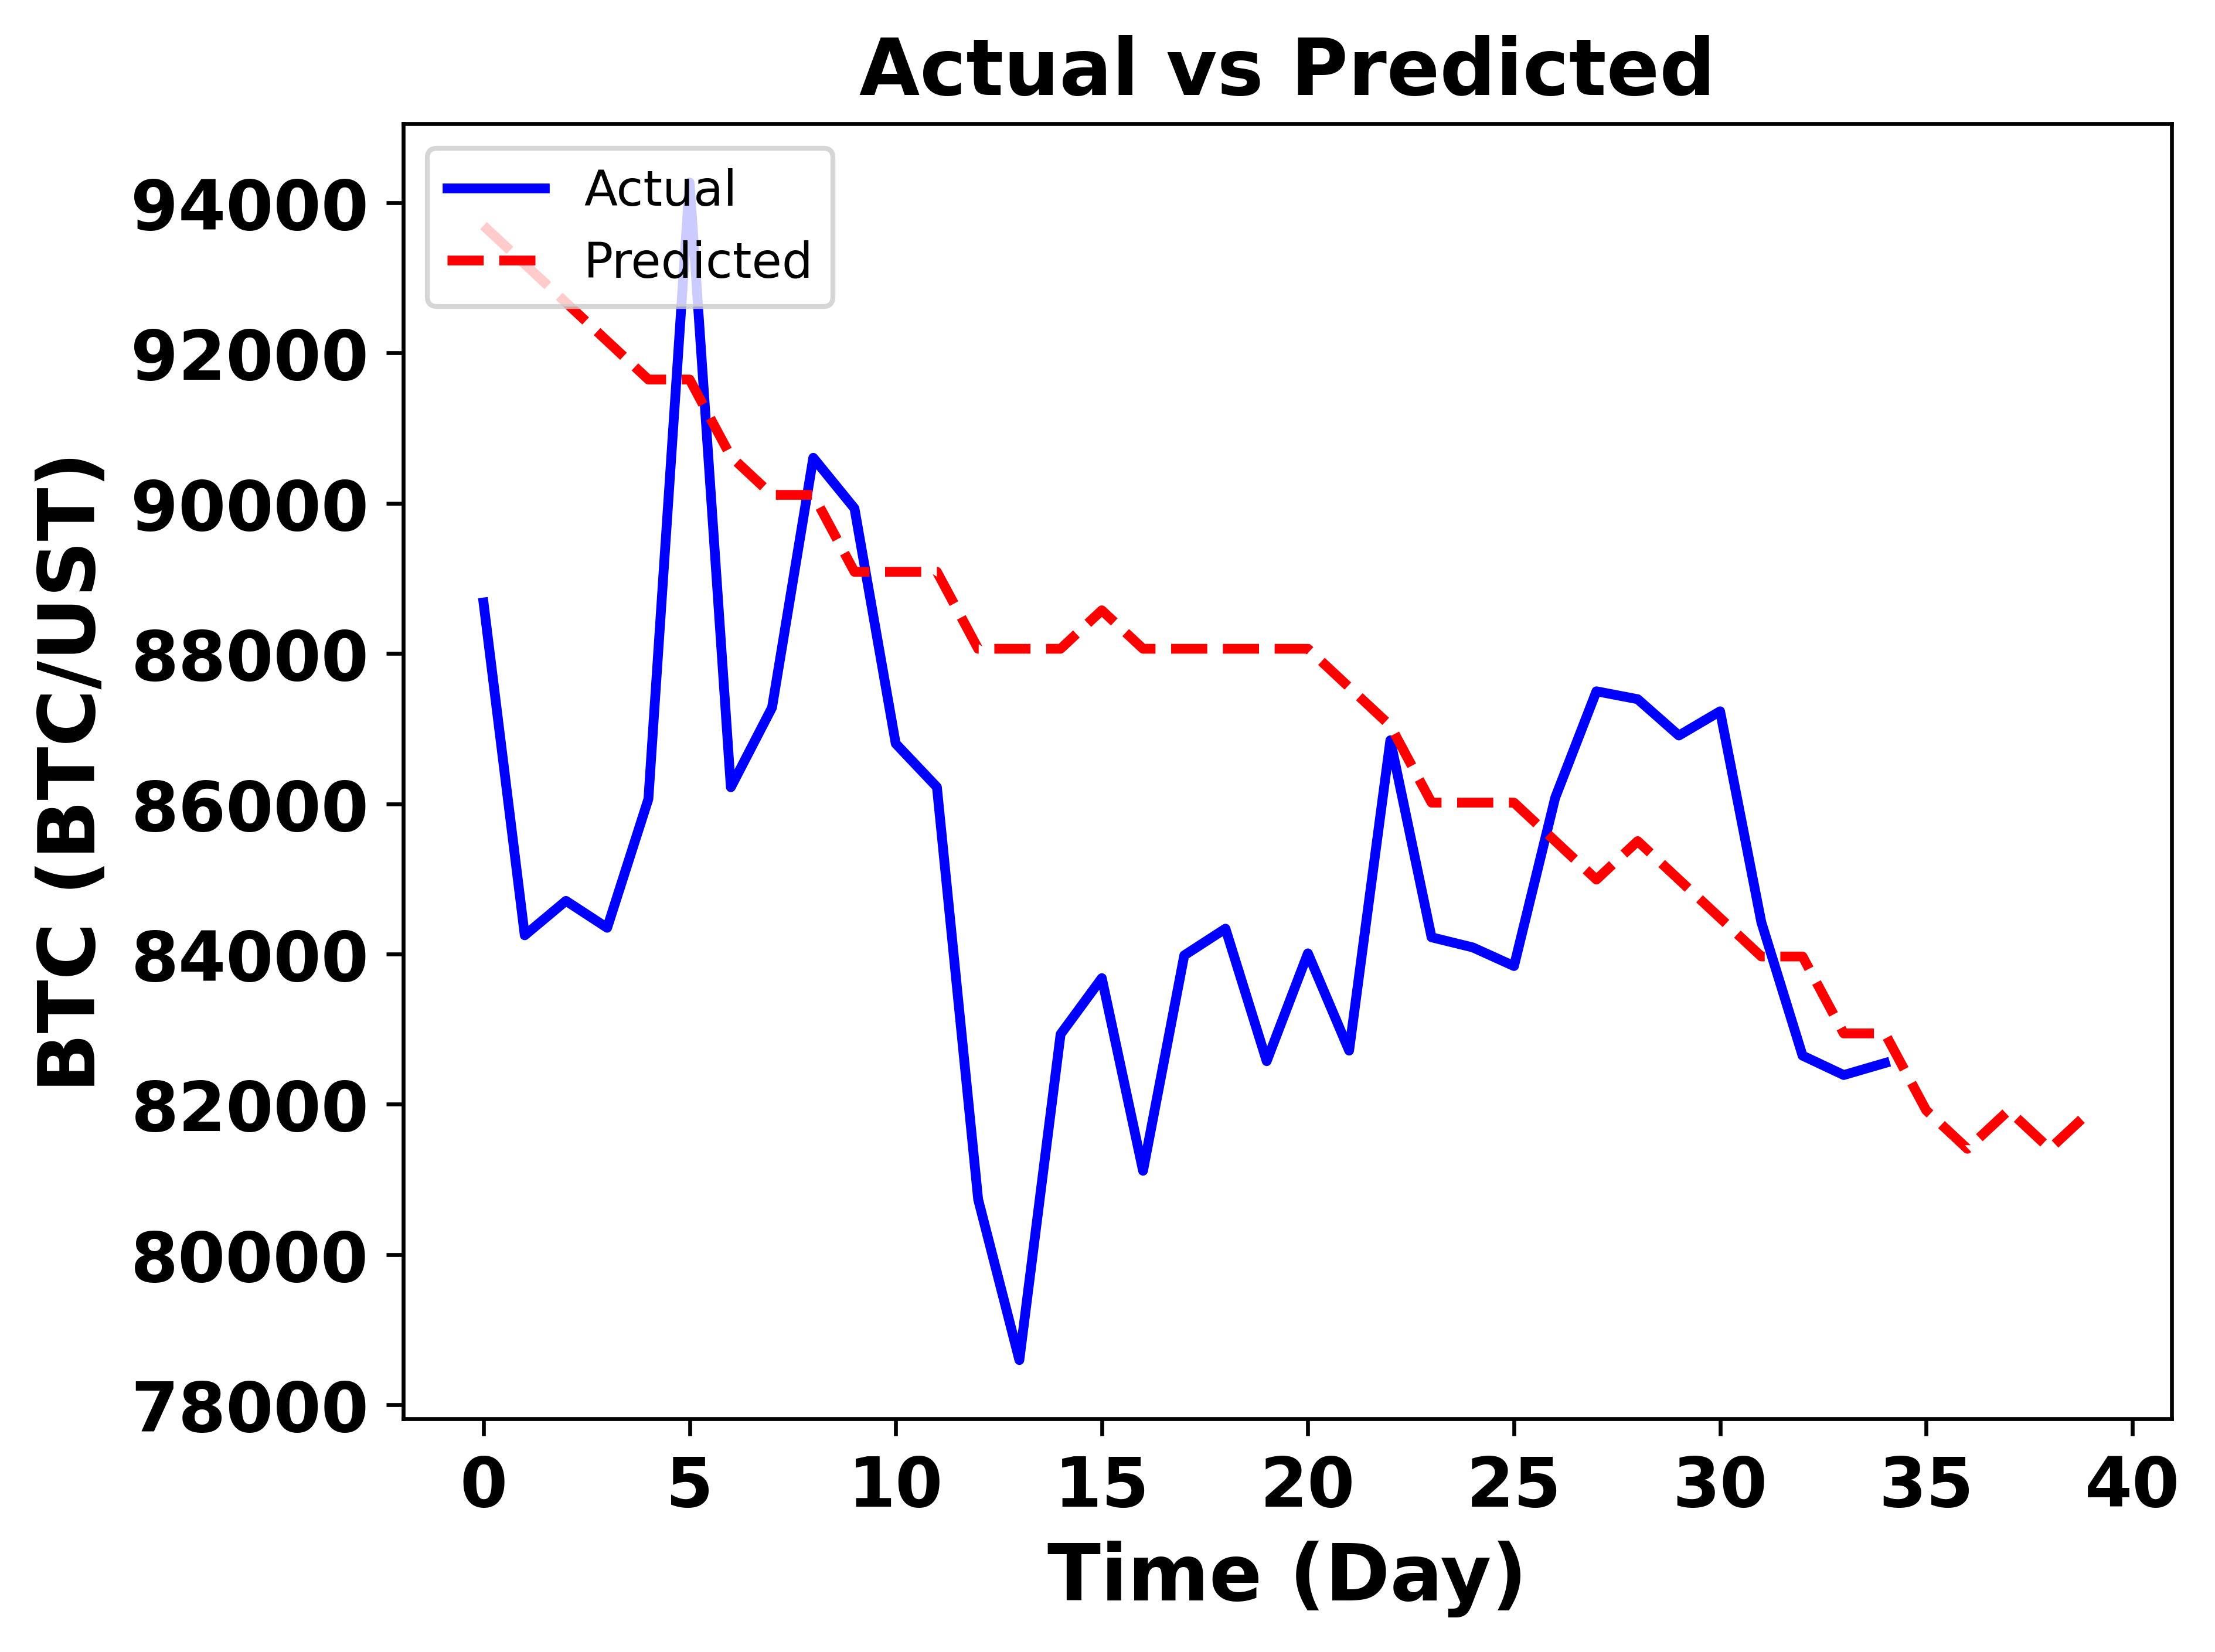

In [47]:
plot_actual_vs_predicted(y_test, pred_test, "resources/timesfm_model_predict.jpeg")

### 4.2. Caso de uso: PatchTST <a class="anchor" id="section_4_2"></a>
<!-- TODO: Probar si hacer o sacar esto. -->

In [ ]:
# from transformers import PatchTSTForPrediction
# import os
# from huggingface_hub import login
# from dotenv import load_dotenv

# load_dotenv()
# huggingface_token = os.environ["HF_TOKEN"]

# login(token=huggingface_token)

# # Split the training data into past values and future values
# split_ratio = 0.9
# train_size = int(len(spots_train) * split_ratio)
# past_values = spots_train[:train_size]
# future_values = spots_train[train_size:]

# # Convert the past values to a tensor
# past_values_tensor = torch.tensor(past_values, dtype=torch.bfloat16).to(DEVICE).unsqueeze(0)  # Add batch dimension
# future_values_tensor = torch.tensor(future_values, dtype=torch.bfloat16).to(DEVICE).unsqueeze(0)  # Add batch dimension

# model = PatchTSTForPrediction.from_pretrained("namctin/patchtst_etth1_forecast")

# # outputs = model(
# #     past_values=past_values_tensor,
# #     future_values=future_values_tensor,
# #     return_dict=True
# # )


Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## 5. Resultados <a class="anchor" id="chapter5"></a>

### 5.1 Conclusiones <a class="anchor" id="section5_1"></a>

En este trabajo se exploró el uso de *Transformers* para series de tiempo, brindando una leve introducción a la arquitectura y su aplicación en el campo de series financieras. 

Se implementaron dos modelos utilizando *Keras*, uno básico y otro con una codificación posicional alternativa, logrando resultados satisfactorios en la predicción de series temporales financieras (similares a modelos clásicos como LSTM o GRU).

También se exploró el uso de modelos pre-entrenados de *HuggingFace*, como `TimesFM` (originalmente de Google), que permite una mayor flexibilidad y adaptabilidad a diferentes series temporales, logrando resultados "interesantes" en la predicción de series temporales financieras.

Como conclusiones finales, se puede destacar que:
- 💡 **El entrenamiento de los modelos "custom" desde cero fue más efectivo que el modelo preentrenado** $\rightarrow$ Esto puede deberse a que `TimesFM` fue entrenado con varios tipos de datos, pero ninguno relacionado a las series financiares. Sin dudas, es evidencia que para las series de tiempo, podría ser muy importante hacer *fine-tuning* de los modelos con varias series del dominio.
- 💡 **El uso de codificación posicional alternativa mejora la capacidad del modelo para capturar patrones temporales** $\rightarrow$ Esto se debe a que la codificación posicional permite al modelo aprender patrones temporales de manera más efectiva, lo que mejora la precisión de las predicciones
- 💡 **El uso de modelos pre-entrenados puede ser útil para tareas específicas, pero no siempre es la mejor opción** $\rightarrow$ Esto se debe a que los modelos pre-entrenados pueden no estar adaptados a las características específicas de los datos, lo que puede afectar la precisión de las predicciones. 
- 💡 **El uso de *Transformers* para series de tiempo es una línea de investigación prometedora** $\rightarrow$ Esto se debe a que los *Transformers* ofrecen ventajas significativas en términos de paralelización, atención y escalabilidad, lo que los hace adecuados para una amplia gama de tareas de series de tiempo, como se comentó al principio. Sin embargo, para este caso, sigue siendo el "mejor" modelo, simplemente predecir lo del día anterior.
- 💡 **Clara diferencia de performance en series temporales a diferencia de NLP** $\rightarrow$ Hay un clara diferencia de performance para estas arquitecturas en dominios del lenguaje natural con respecto al dominio de series temporales. Esto puede deberse a que en estos casos, donde los datos son escasos (solamente se intentó predecir con 1 año de datos), modelos con *high inductive bias* funcionan mejor que modelos con *low inductive bias*. Esto lo podemos evidenciar en que modelos clásicos como ARIMA han dado mejores resultados.
- 💡 **El uso de *Transformers* para series de tiempo también requiere de muchos datos** $\rightarrow$ Con los resultados, pudimos observar que se necesitan muchos más datos para que mejore la performance del modelo (relacionado al comentario anterior).

### 5.2 Mejoras y futuras lineas de investigación <a class="anchor" id="section5_2"></a>

Entre las mejoras y futuras líneas de investigación, se pueden destacar las siguientes:
- 💫 *Optimización de parámetros y arquitectura*: Sin duda un punto fuerte de este trabajo la no optimización de la arquitectura e hiperparámetros. Esto se debe a una restricción temporal, pero sería interesante realizar este proceso para los modelos "custom".
- 💫 *Realizar _fine-tuning_ sobre el modelo `TimesFM`*: Creemos que es muy importante para estos casos que los modelos estén pre-entrenados con datos relacionados. Es por esto, que se sugiere probar realizar *fine-tuning* sobre este modelo con series financieras similares.
- 💫 *Probar con otros modelos pre-entrenados*: Existen otros modelos pre-entrenados que podrían ser útiles para este caso, como `LogTrans` o `Informer`, que podrían mejorar la precisión de las predicciones.
- 💫 *Aumentar la cantidad de datos*: Sin dudas mejoraría la performance de estas arquitecturas tener más datos, como en NLP. En este ejemplo se evidenció que el *Transformer* no logra generalizar correctamente con esta cantidad de datos.
- 💫 *Explorar otras características y embeddings*: En este caso, se mejoró con la incorporación de *embeddings*. Esto podría dar lugar a explorar esta linea de mejor generación de embeddings como incorporar más características a la serie.
- 💫 **Tamaño de ventana**: En esta exploración se utilizó simplemente un tamaño de ventana chico para continuar con el análisis previo pero se podría incluir en la optimización de hiperparámetros o investigar más su inferencia.
<!-- - 💫 **Serie univariable en PatchTST:** $\rightarrow$ La forma de implementar PatchTST en el ejemplo no es del todo alineada con el paper, dado que este propone utilizar varias series temporales y en este caso se utilizó solamente una (la de Bitcoin). Pero lo ideal sería realizar un análisis con varias series en varios canales. -->

## 6. Referencias <a class="anchor" id="chapter6"></a>

- https://www.reddit.com/r/MachineLearning/comments/1k63r4a/d_is_my_take_on_transformers_in_time_series/